In [1]:
%load_ext autoreload
%autoreload complete

Trying to get some insights into the hyperparameter choice by using propensity score matching on it.

In [2]:
import optuna

studies = optuna.study.get_all_study_summaries(
    storage="sqlite:///../../hyperopt/synth_single_protests_2.db"
)

In [3]:
study_names = [
    s.study_name
    for s in studies
    if s.study_name.startswith("synth_single_protests_v10243453")
]
study_names

['synth_single_protests_v10243453_6d86e6177f6e279e4adb17442b70dc85',
 'synth_single_protests_v10243453_2fa8e1c7fff30fb59275c4333001ce3f',
 'synth_single_protests_v10243453_c5653bb3f825cd2c21648d2e0f8aba85',
 'synth_single_protests_v10243453_7165487e41fe094dfe6539adfc1d3d4b',
 'synth_single_protests_v10243453_a52fb6276d99978e98c07cb8acd0843f',
 'synth_single_protests_v10243453_a2d70381a634218a40add43302d6ad8f',
 'synth_single_protests_v10243453_ee7891fc979b54ce1d02b4ad52b738a6',
 'synth_single_protests_v10243453_369cf68196a9aed9f2bec228d68af7f9',
 'synth_single_protests_v10243453_9e4c9034a7c78b03a20857ab36a14831',
 'synth_single_protests_v10243453_fab51e1ee4ab4c474ee6a494697c0cc5',
 'synth_single_protests_v10243453_1dc3a2cc0ddb6a70f691b6ce97b27580',
 'synth_single_protests_v10243453_1412cd4e692ac8b6e2eac2ce5ee0166d',
 'synth_single_protests_v10243453_cc35bdadf60f7d2048d26903874736ae']

In [4]:
study = optuna.load_study(
    study_names[0], storage="sqlite:///../../hyperopt/synth_single_protests_2.db"
)
df = study.trials_dataframe()
df = df[df.state == "COMPLETE"]

/var/folders/6v/w9nn6c_n4qdbrjwfnq7695n00000gn/T/ipykernel_32583/4054739169.py:1: FutureWarning: load_study(): Please give all values as keyword arguments. See https://github.com/optuna/optuna/issues/3324 for details.
  study = optuna.load_study(study_names[0], storage="sqlite:///../../hyperopt/synth_single_protests_2.db")


In [5]:
params = df.columns[df.columns.str.startswith("params_")]

params_alpha


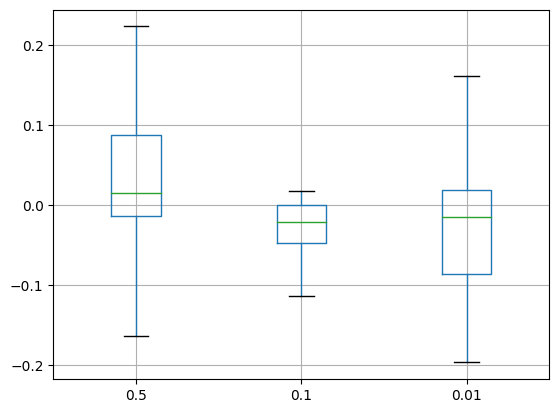

params_distance__inverse


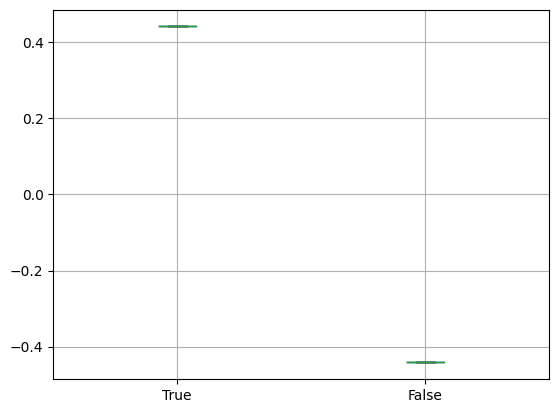

params_interpretable


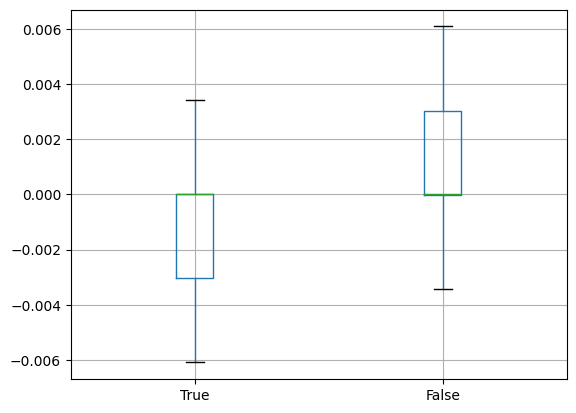

params_lags


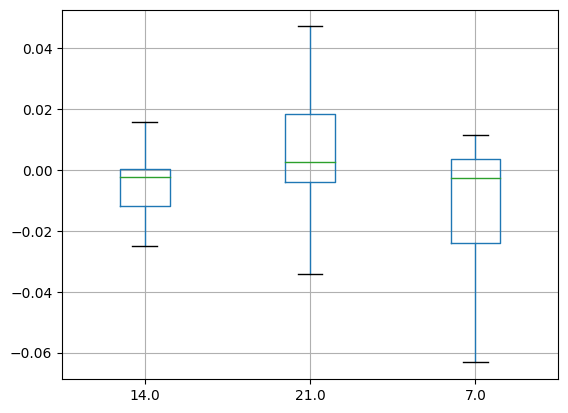

params_normalize


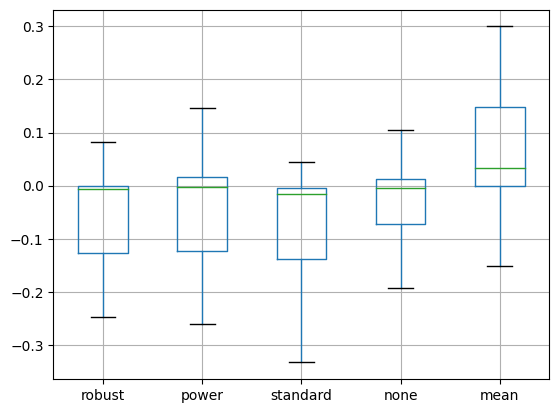

params_readjust


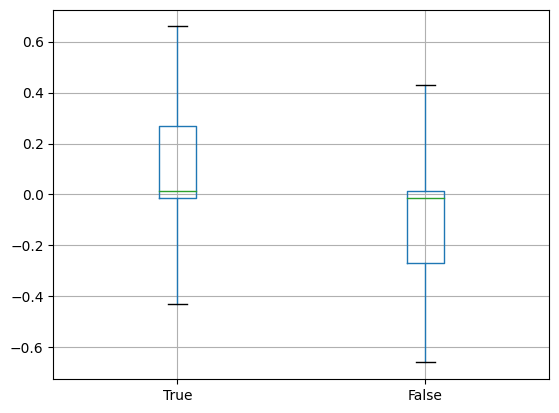

params_socioeconomic__k


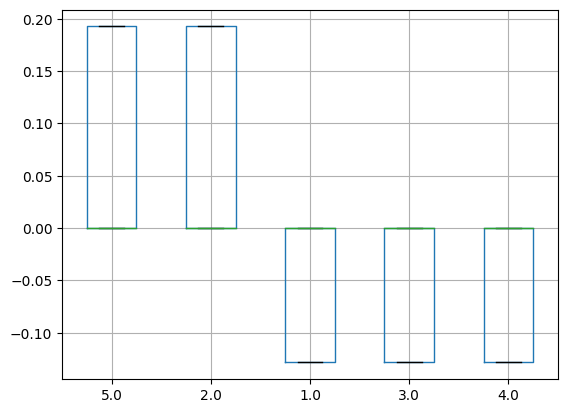

params_socioeconomic__method


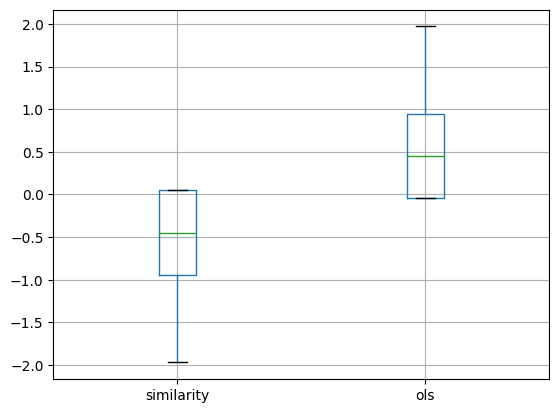

params_training_interval


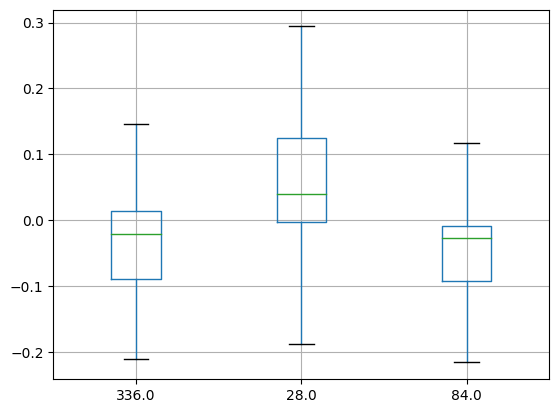

In [6]:
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd

for param in params:
    nvals = df[param].nunique(dropna=True)
    groups = df[~df[param].isna()].groupby(
        [p for p in params if p != param], dropna=False
    )
    diffs = defaultdict(list)
    for _, group in groups:
        if group[param].nunique(dropna=True) != nvals:
            continue
        for val in group[param].unique():
            group_val = group[group[param] == val]
            group_not_val = group[group[param] != val]
            diff = group_val.value.mean() - group_not_val.value.mean()
            diffs[val].append(diff)
    diffs = pd.DataFrame(diffs)
    if len(diffs) > 0:
        print(param)
        diffs.boxplot(showfliers=False)
        plt.show()

In [8]:
import optuna

db = "sqlite:///../../hyperopt/synth_single_protests_3.db"
studies = optuna.study.get_all_study_summaries(storage=db)
study_names = [s.study_name for s in studies]
study_names

['synth_single_protests_v0324_6d86e6177f6e279e4adb17442b70dc85_topic_focused',
 'synth_single_protests_v0324_6d86e6177f6e279e4adb17442b70dc85_protest_focused',
 'synth_single_protests_v0324_2fa8e1c7fff30fb59275c4333001ce3f_topic_focused',
 'synth_single_protests_v0324_2fa8e1c7fff30fb59275c4333001ce3f_protest_focused',
 'synth_single_protests_v0324_c5653bb3f825cd2c21648d2e0f8aba85_topic_focused',
 'synth_single_protests_v0324_c5653bb3f825cd2c21648d2e0f8aba85_protest_focused',
 'synth_single_protests_v0324_7165487e41fe094dfe6539adfc1d3d4b_protest_focused',
 'synth_single_protests_v0324_7165487e41fe094dfe6539adfc1d3d4b_topic_focused',
 'synth_single_protests_v0324_a52fb6276d99978e98c07cb8acd0843f_protest_focused',
 'synth_single_protests_v0324_a52fb6276d99978e98c07cb8acd0843f_topic_focused',
 'synth_single_protests_v0324_a2d70381a634218a40add43302d6ad8f_topic_focused',
 'synth_single_protests_v0324_a2d70381a634218a40add43302d6ad8f_protest_focused',
 'synth_single_protests_v0324_ee7891fc97

topic


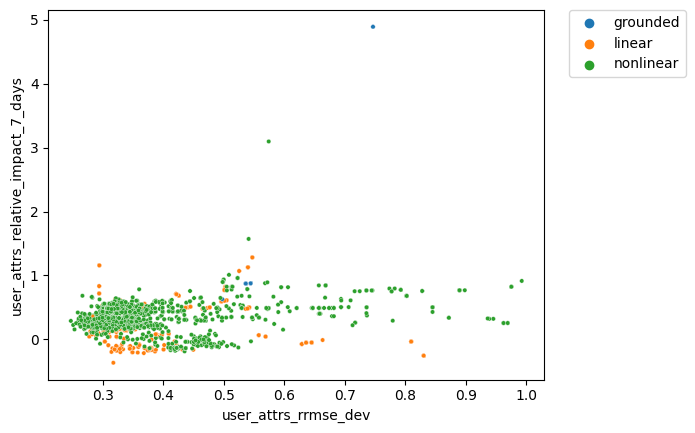

protest


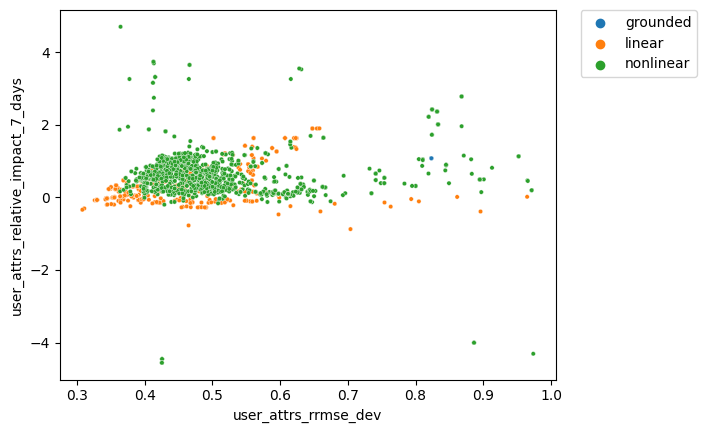

topic


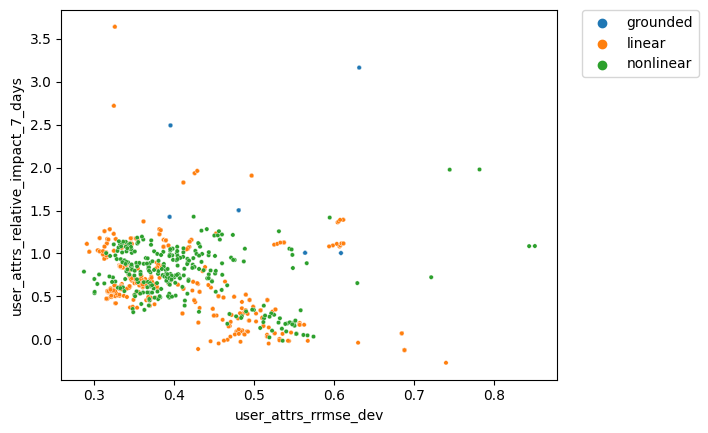

protest


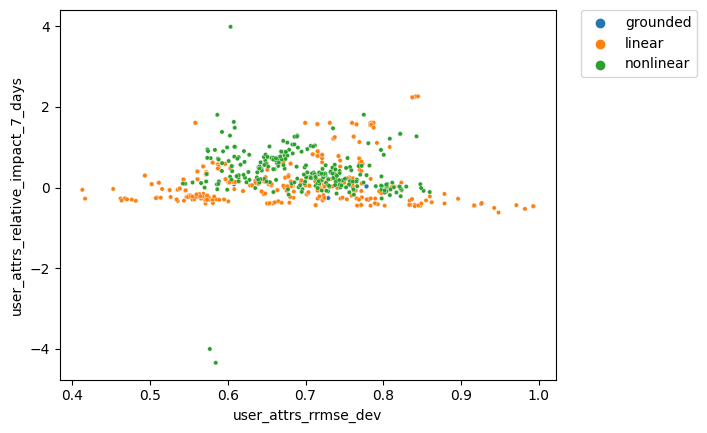

topic


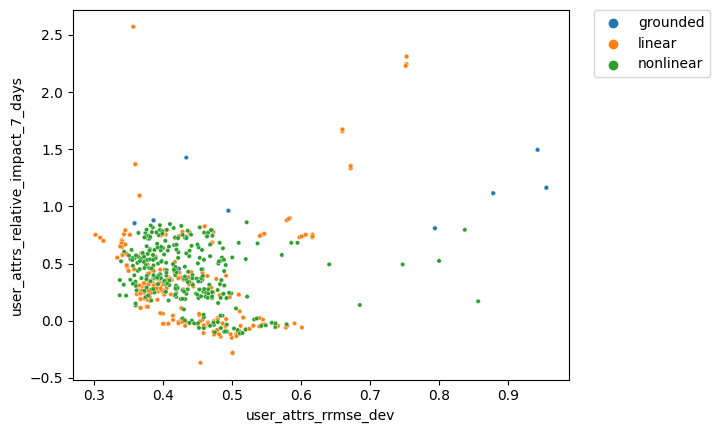

protest


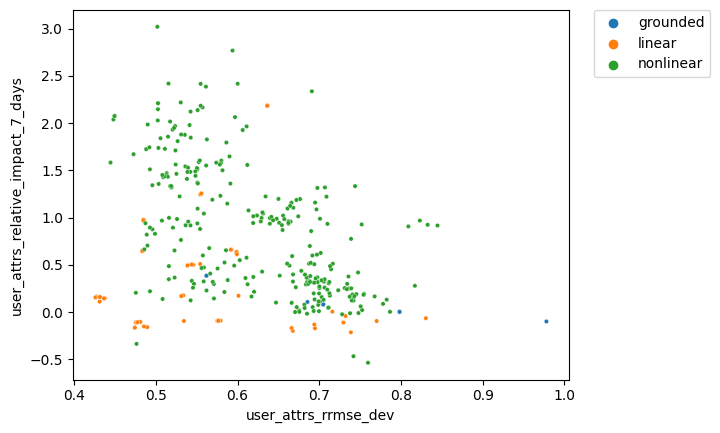

protest


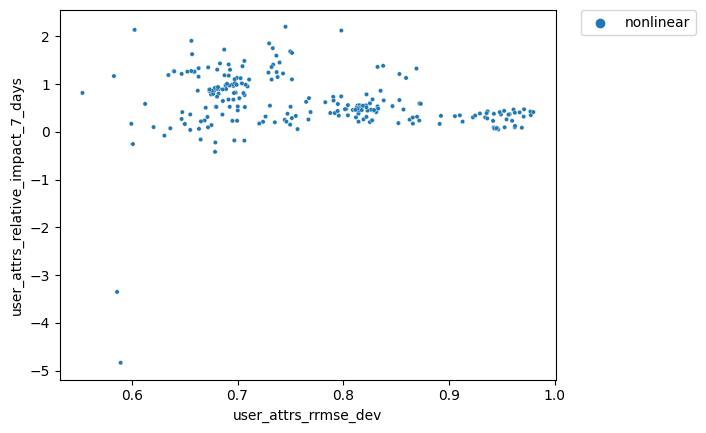

topic


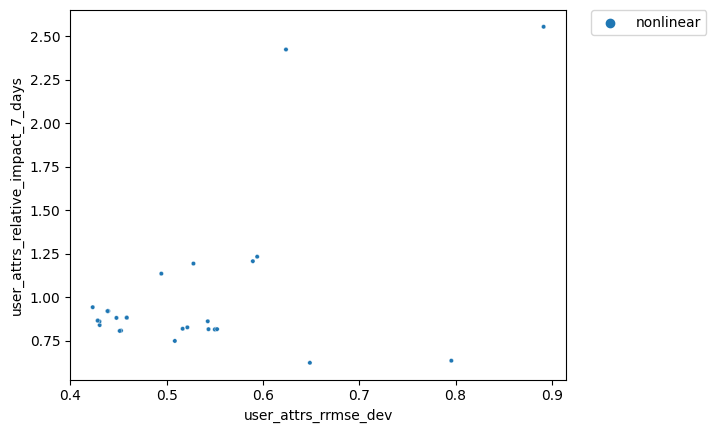

protest


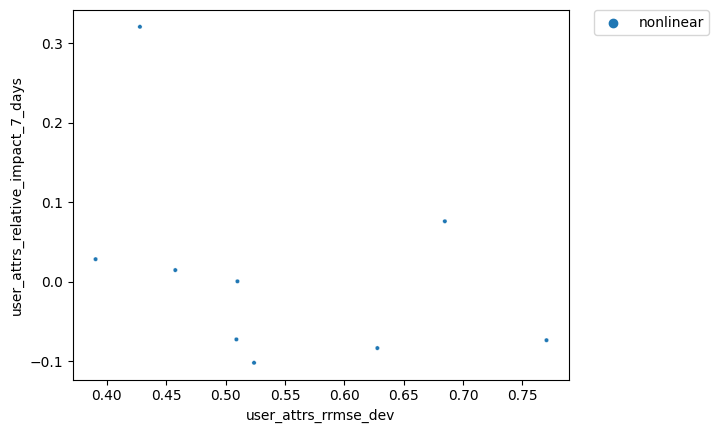

topic


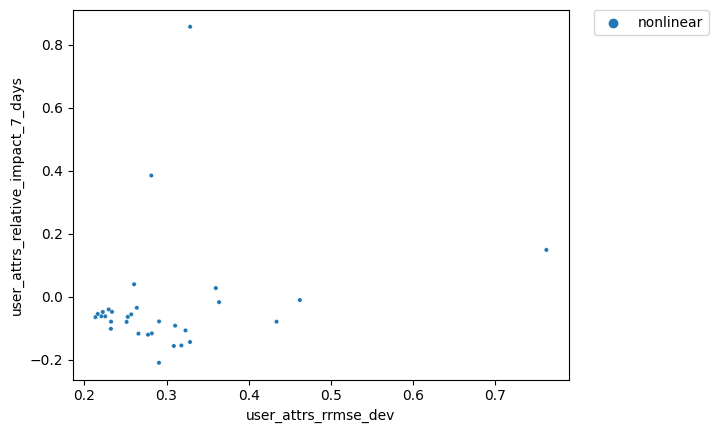

topic


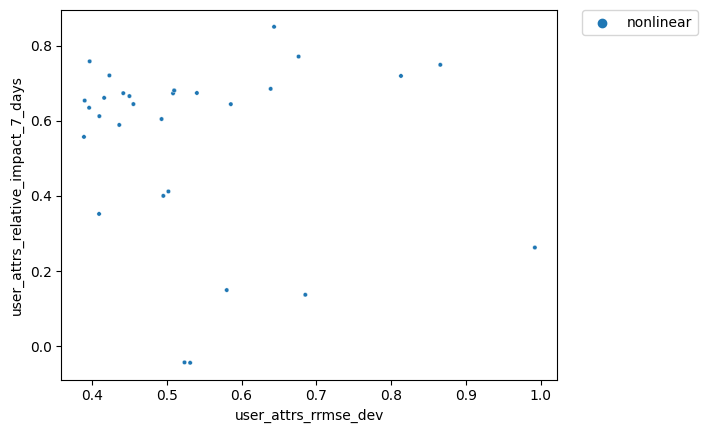

protest


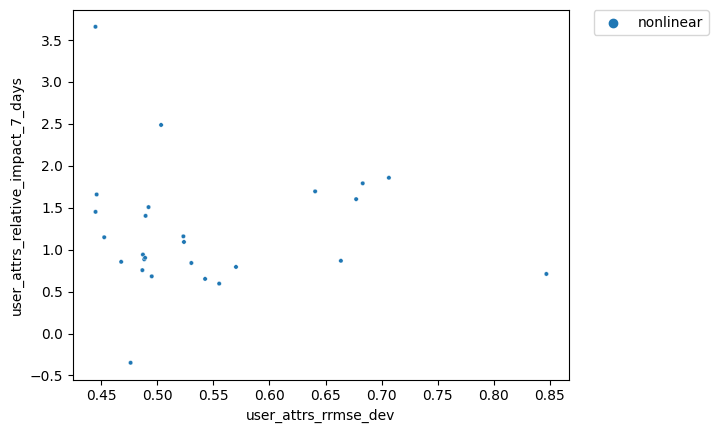

protest


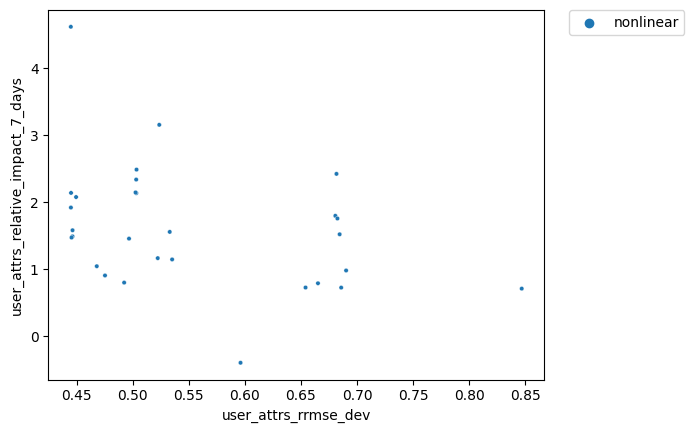

protest


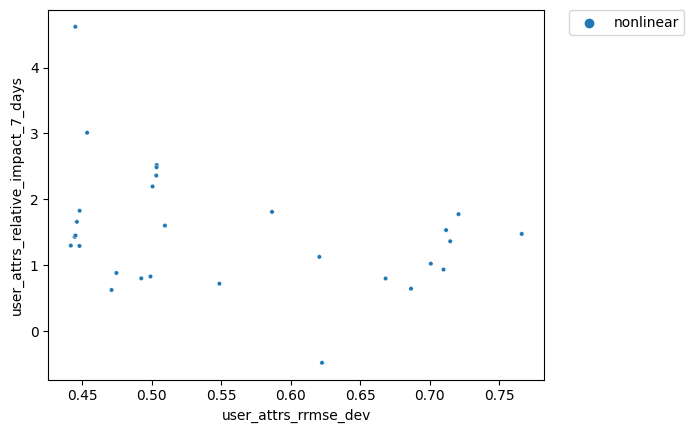

protest


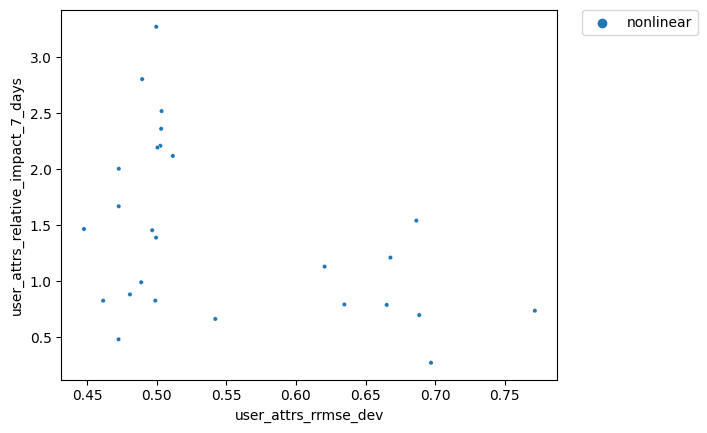

topic


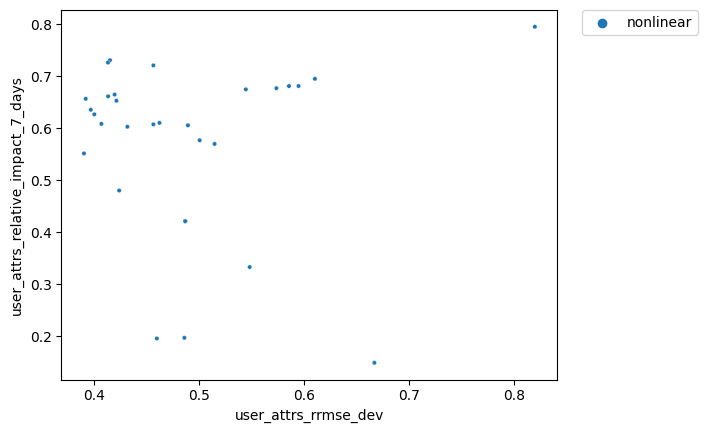

topic


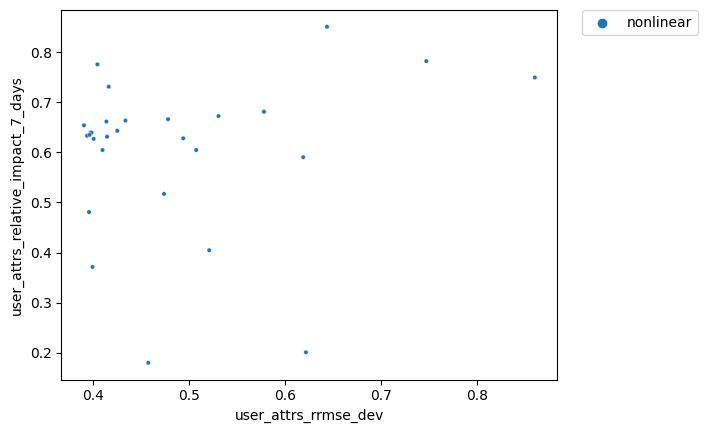

topic


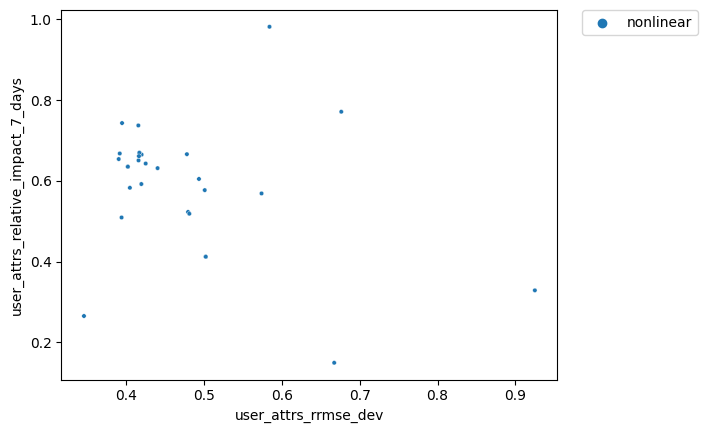

topic


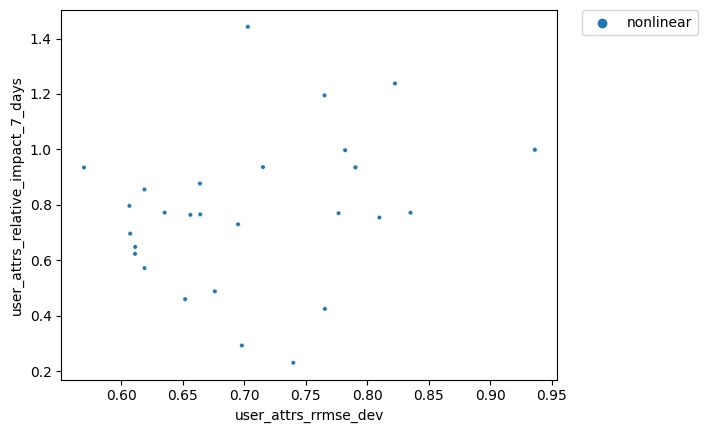

protest


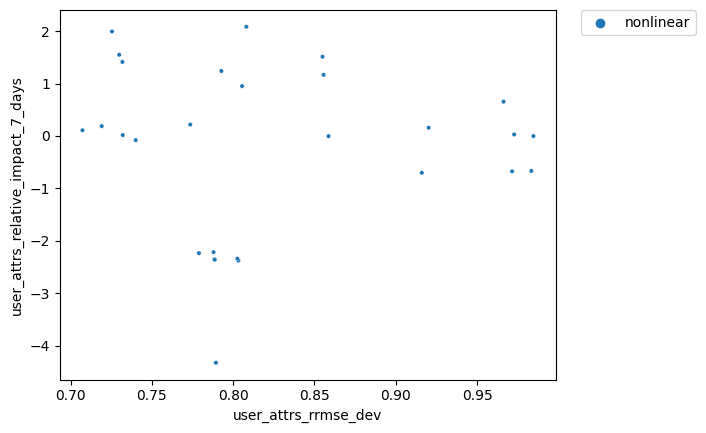

topic


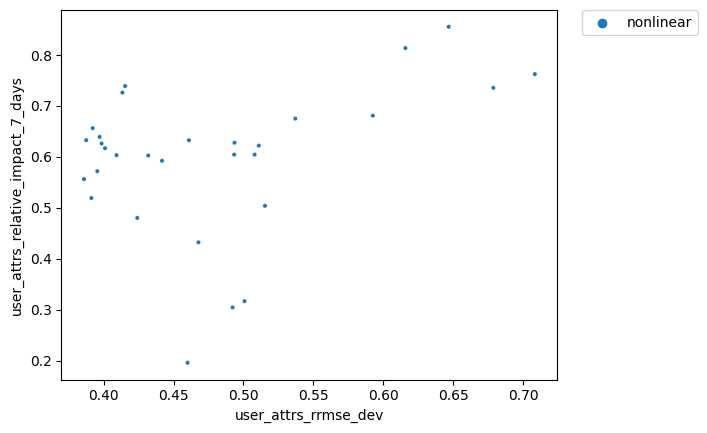

protest


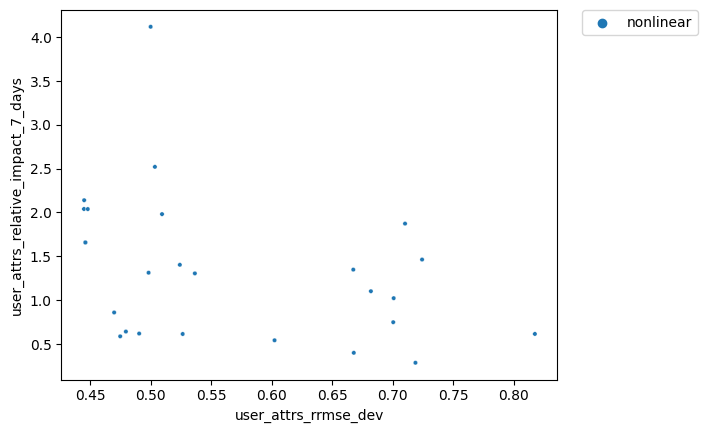

topic


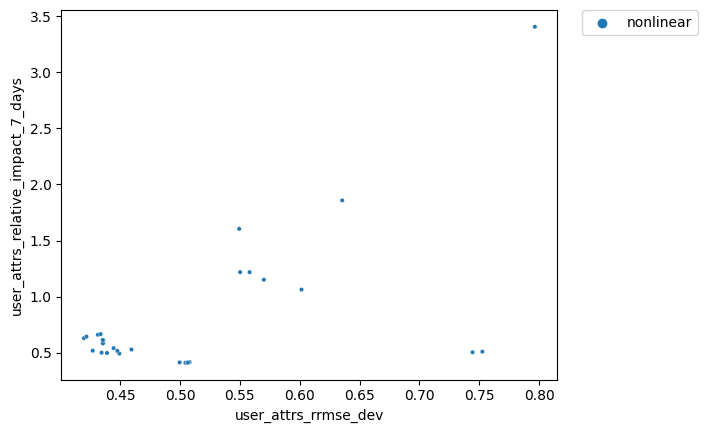

protest


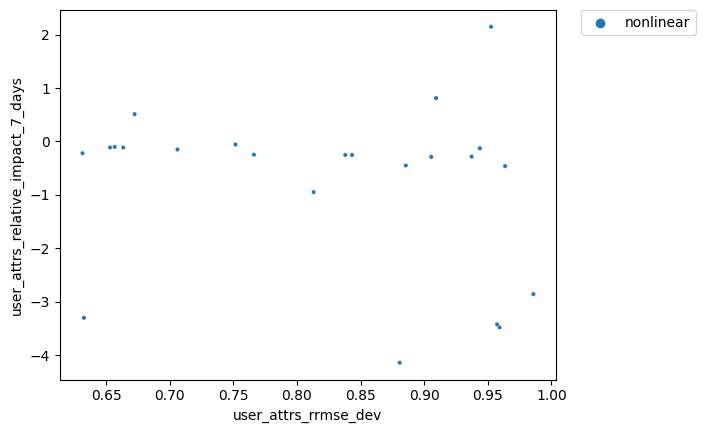

topic


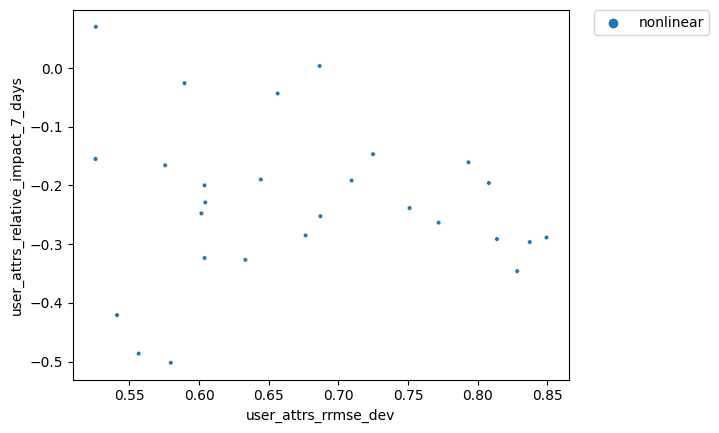

topic


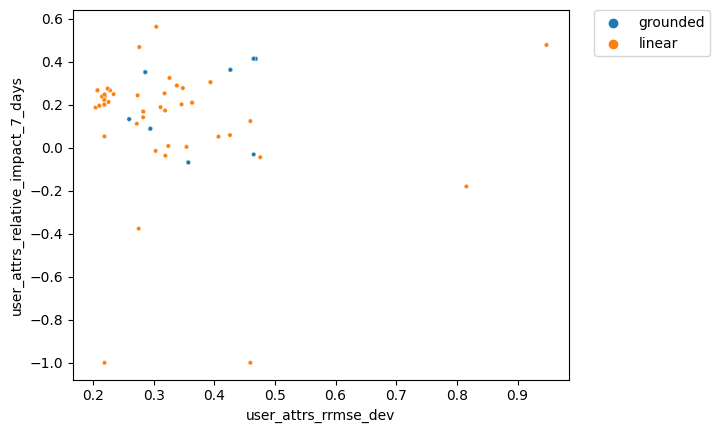

In [9]:
import json

import seaborn as sns

for s in study_names:
    study = optuna.load_study(study_name=s, storage=db)
    print(s.split("_")[-2])
    df = study.trials_dataframe()
    df = df[df.state == "COMPLETE"]
    df = df[(df["value"] < 1) & (df["user_attrs_relative_impact_7_days"].abs() < 5)]
    hue = "user_attrs_method_group"
    # hue = "params_method"
    sns.scatterplot(
        data=df,
        x="user_attrs_rrmse_dev",
        y="user_attrs_relative_impact_7_days",
        hue=hue,
        s=10,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()
    # best_trial = df[df["user_attrs_method_group"]=="grounded"].sort_values("value").iloc[0]
    # ts = pd.DataFrame(json.loads(best_trial["user_attrs_comparison_df"]))
    # ts.index = ts.index.astype(int)
    # ts.loc[-28:28].plot()
    # plt.show()

topic
grounded
params_alpha                              NaN
params_distance__inverse                  NaN
params_interpretable                      NaN
params_lags                               NaN
params_lam                                NaN
params_max_depth                          NaN
params_max_features                       NaN
params_method                   socioeconomic
params_min_samples_leaf                   NaN
params_min_samples_split                  NaN
params_n_estimators                       NaN
params_n_splines                          NaN
params_normalize                         none
params_readjust                           NaN
params_socioeconomic__k                   5.0
params_socioeconomic__method              ols
params_spline_order                       NaN
params_training_interval                 28.0
params_use_autoregressor                  NaN
Name: 46, dtype: object


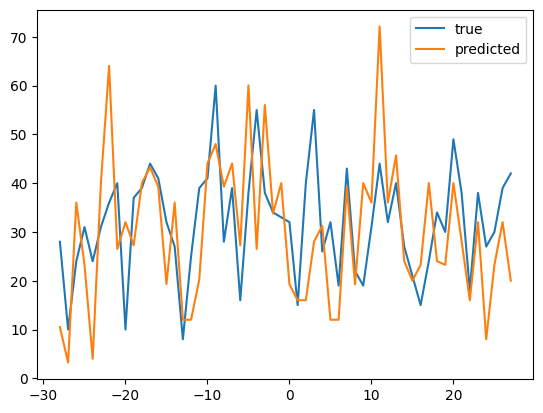

linear
params_alpha                      NaN
params_distance__inverse          NaN
params_interpretable             True
params_lags                       7.0
params_lam                        NaN
params_max_depth                  NaN
params_max_features               NaN
params_method                   ridge
params_min_samples_leaf           NaN
params_min_samples_split          NaN
params_n_estimators               NaN
params_n_splines                  NaN
params_normalize                 mean
params_readjust                   NaN
params_socioeconomic__k           NaN
params_socioeconomic__method      NaN
params_spline_order               NaN
params_training_interval         28.0
params_use_autoregressor         True
Name: 277, dtype: object


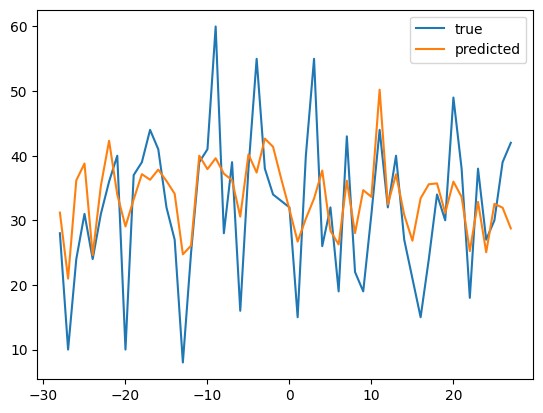

nonlinear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                          NaN
params_lags                                  14.0
params_lam                                    NaN
params_max_depth                             20.0
params_max_features                          sqrt
params_method                   gradient_boosting
params_min_samples_leaf                       1.0
params_min_samples_split                     10.0
params_n_estimators                         100.0
params_n_splines                              NaN
params_normalize                             mean
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                     True
Name: 1636, dtype: object


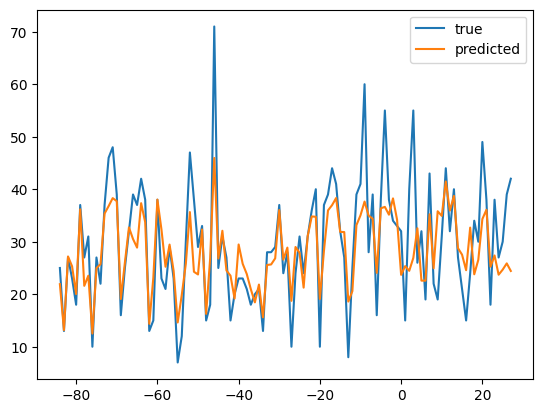

interpretable
params_alpha                      NaN
params_distance__inverse          NaN
params_interpretable             True
params_lags                       NaN
params_lam                        NaN
params_max_depth                  NaN
params_max_features               NaN
params_method                   ridge
params_min_samples_leaf           NaN
params_min_samples_split          NaN
params_n_estimators               NaN
params_n_splines                  NaN
params_normalize                 mean
params_readjust                   NaN
params_socioeconomic__k           NaN
params_socioeconomic__method      NaN
params_spline_order               NaN
params_training_interval         28.0
params_use_autoregressor        False
Name: 286, dtype: object


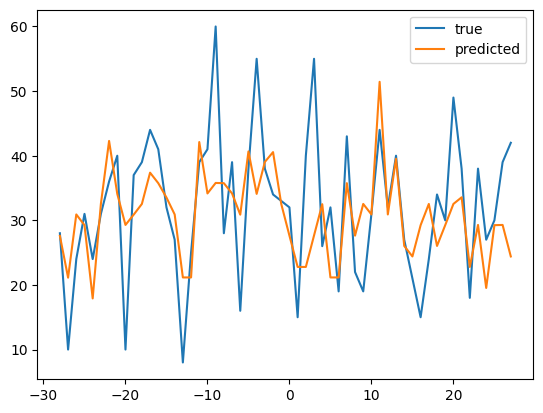

protest
grounded
params_alpha                         NaN
params_distance__inverse            True
params_interpretable                 NaN
params_lags                          NaN
params_lam                           NaN
params_max_depth                     NaN
params_max_features                  NaN
params_method                   distance
params_min_samples_leaf              NaN
params_min_samples_split             NaN
params_n_estimators                  NaN
params_n_splines                     NaN
params_normalize                    none
params_readjust                      NaN
params_socioeconomic__k              NaN
params_socioeconomic__method         NaN
params_spline_order                  NaN
params_training_interval            28.0
params_use_autoregressor             NaN
Name: 1858, dtype: object


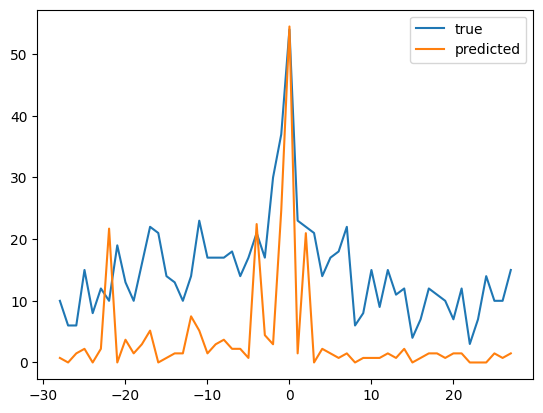

linear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                         True
params_lags                                  21.0
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                             mean
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                     True
Name: 210, dtype: object


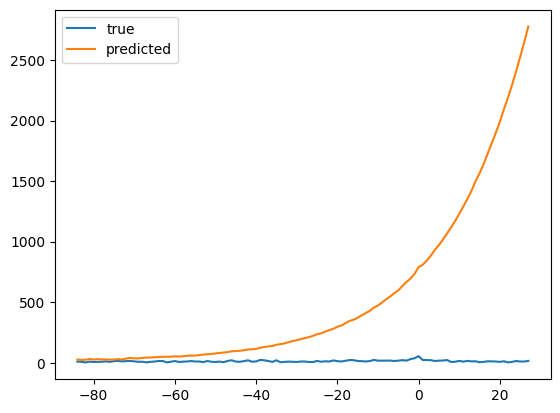

nonlinear
params_alpha                     NaN
params_distance__inverse         NaN
params_interpretable             NaN
params_lags                      NaN
params_lam                      0.01
params_max_depth                 NaN
params_max_features              NaN
params_method                    gam
params_min_samples_leaf          NaN
params_min_samples_split         NaN
params_n_estimators              NaN
params_n_splines                10.0
params_normalize                none
params_readjust                  NaN
params_socioeconomic__k          NaN
params_socioeconomic__method     NaN
params_spline_order              3.0
params_training_interval        28.0
params_use_autoregressor         NaN
Name: 2771, dtype: object


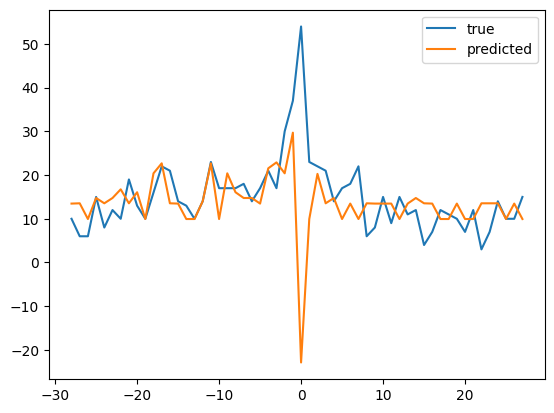

interpretable
params_alpha                      NaN
params_distance__inverse          NaN
params_interpretable             True
params_lags                       NaN
params_lam                        NaN
params_max_depth                  NaN
params_max_features               NaN
params_method                   ridge
params_min_samples_leaf           NaN
params_min_samples_split          NaN
params_n_estimators               NaN
params_n_splines                  NaN
params_normalize                 mean
params_readjust                   NaN
params_socioeconomic__k           NaN
params_socioeconomic__method      NaN
params_spline_order               NaN
params_training_interval         28.0
params_use_autoregressor        False
Name: 280, dtype: object


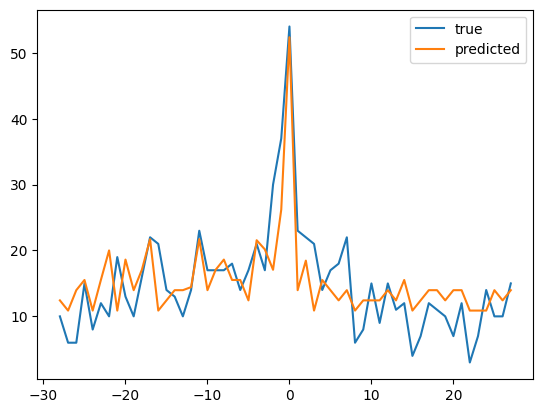

topic
grounded
params_alpha                     NaN
params_distance__inverse         NaN
params_interpretable             NaN
params_lags                      NaN
params_lam                       NaN
params_max_depth                 NaN
params_max_features              NaN
params_method                   mean
params_min_samples_leaf          NaN
params_min_samples_split         NaN
params_n_estimators              NaN
params_n_splines                 NaN
params_normalize                none
params_readjust                  NaN
params_socioeconomic__k          NaN
params_socioeconomic__method     NaN
params_spline_order              NaN
params_training_interval        28.0
params_use_autoregressor         NaN
Name: 4, dtype: object


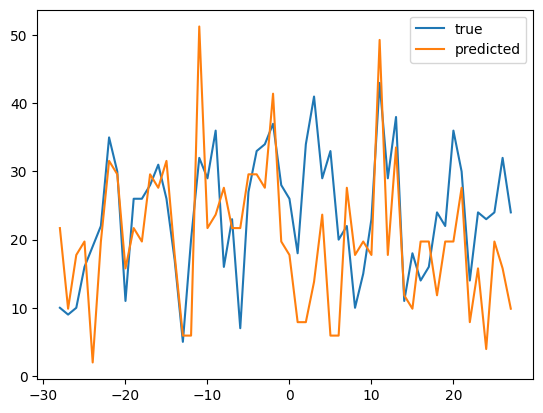

linear
params_alpha                        0.01
params_distance__inverse             NaN
params_interpretable               False
params_lags                          NaN
params_lam                           NaN
params_max_depth                     NaN
params_max_features                  NaN
params_method                      lasso
params_min_samples_leaf              NaN
params_min_samples_split             NaN
params_n_estimators                  NaN
params_n_splines                     NaN
params_normalize                standard
params_readjust                     True
params_socioeconomic__k              NaN
params_socioeconomic__method         NaN
params_spline_order                  NaN
params_training_interval           336.0
params_use_autoregressor           False
Name: 1145, dtype: object


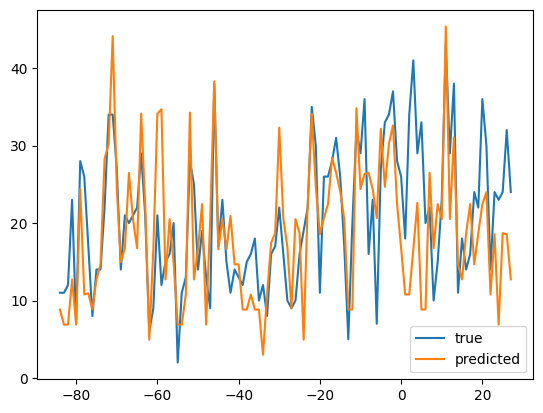

nonlinear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                          NaN
params_lags                                   7.0
params_lam                                    NaN
params_max_depth                              5.0
params_max_features                           0.5
params_method                   gradient_boosting
params_min_samples_leaf                       1.0
params_min_samples_split                      5.0
params_n_estimators                         100.0
params_n_splines                              NaN
params_normalize                             none
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                    336.0
params_use_autoregressor                     True
Name: 1575, dtype: object


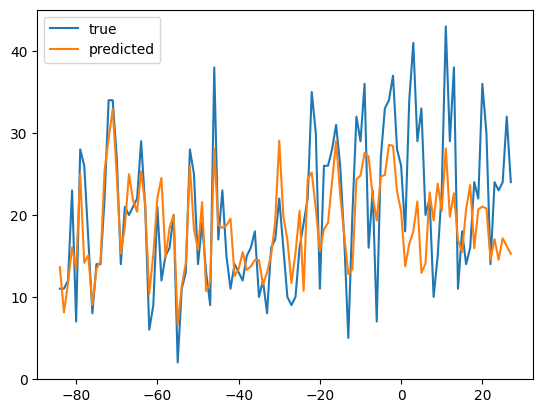

interpretable
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                         True
params_lags                                   NaN
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                             mean
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                    False
Name: 120, dtype: object


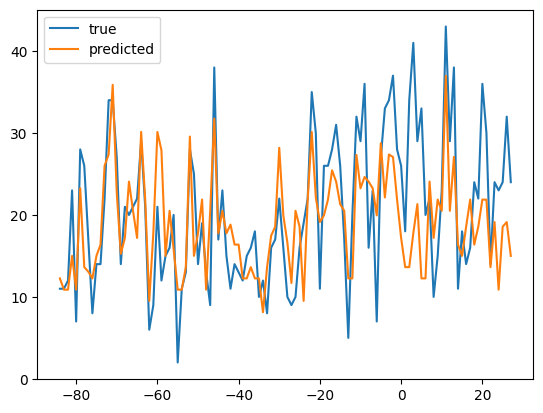

protest
grounded
params_alpha                         NaN
params_distance__inverse           False
params_interpretable                 NaN
params_lags                          NaN
params_lam                           NaN
params_max_depth                     NaN
params_max_features                  NaN
params_method                   distance
params_min_samples_leaf              NaN
params_min_samples_split             NaN
params_n_estimators                  NaN
params_n_splines                     NaN
params_normalize                    none
params_readjust                      NaN
params_socioeconomic__k              NaN
params_socioeconomic__method         NaN
params_spline_order                  NaN
params_training_interval            28.0
params_use_autoregressor             NaN
Name: 20, dtype: object


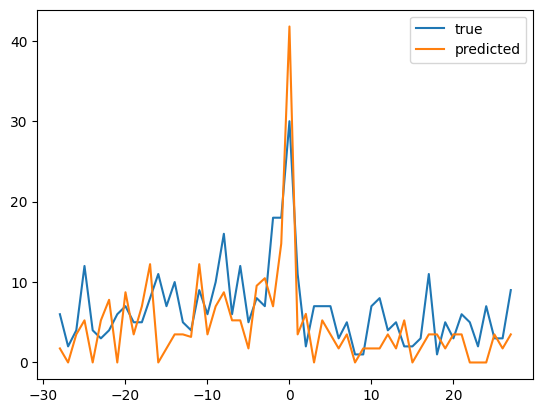

linear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                        False
params_lags                                   7.0
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                            power
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     28.0
params_use_autoregressor                     True
Name: 265, dtype: object


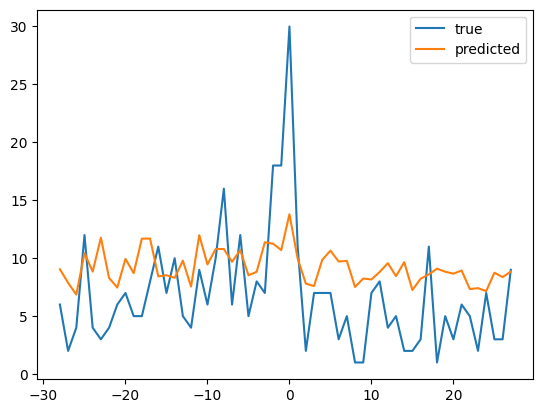

nonlinear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                          NaN
params_lags                                   7.0
params_lam                                    NaN
params_max_depth                              5.0
params_max_features                          sqrt
params_method                   gradient_boosting
params_min_samples_leaf                       1.0
params_min_samples_split                      2.0
params_n_estimators                         100.0
params_n_splines                              NaN
params_normalize                            power
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                     True
Name: 1673, dtype: object


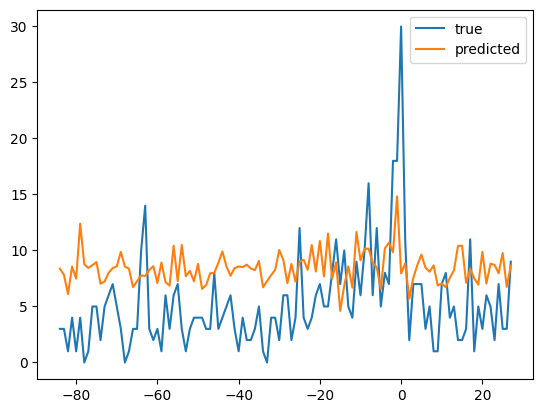

interpretable
params_alpha                      NaN
params_distance__inverse          NaN
params_interpretable             True
params_lags                       NaN
params_lam                        NaN
params_max_depth                  NaN
params_max_features               NaN
params_method                   ridge
params_min_samples_leaf           NaN
params_min_samples_split          NaN
params_n_estimators               NaN
params_n_splines                  NaN
params_normalize                 mean
params_readjust                   NaN
params_socioeconomic__k           NaN
params_socioeconomic__method      NaN
params_spline_order               NaN
params_training_interval        336.0
params_use_autoregressor        False
Name: 140, dtype: object


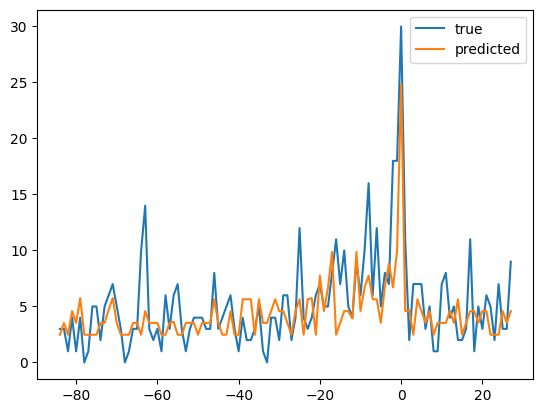

topic
grounded
params_alpha                     NaN
params_distance__inverse         NaN
params_interpretable             NaN
params_lags                      NaN
params_lam                       NaN
params_max_depth                 NaN
params_max_features              NaN
params_method                   mean
params_min_samples_leaf          NaN
params_min_samples_split         NaN
params_n_estimators              NaN
params_n_splines                 NaN
params_normalize                none
params_readjust                  NaN
params_socioeconomic__k          NaN
params_socioeconomic__method     NaN
params_spline_order              NaN
params_training_interval        28.0
params_use_autoregressor         NaN
Name: 7, dtype: object


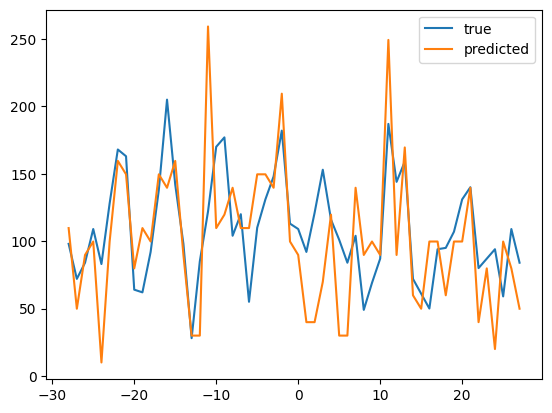

linear
params_alpha                       0.5
params_distance__inverse           NaN
params_interpretable             False
params_lags                        NaN
params_lam                         NaN
params_max_depth                   NaN
params_max_features                NaN
params_method                    lasso
params_min_samples_leaf            NaN
params_min_samples_split           NaN
params_n_estimators                NaN
params_n_splines                   NaN
params_normalize                robust
params_readjust                   True
params_socioeconomic__k            NaN
params_socioeconomic__method       NaN
params_spline_order                NaN
params_training_interval         336.0
params_use_autoregressor         False
Name: 1343, dtype: object


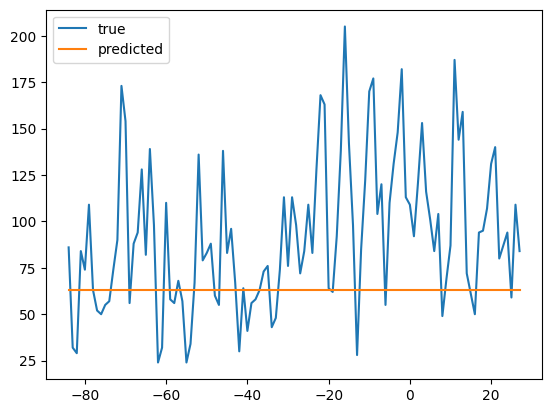

nonlinear
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                          NaN
params_lags                                  14.0
params_lam                                    NaN
params_max_depth                              5.0
params_max_features                           1.0
params_method                   gradient_boosting
params_min_samples_leaf                       4.0
params_min_samples_split                      5.0
params_n_estimators                         100.0
params_n_splines                              NaN
params_normalize                             mean
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                    336.0
params_use_autoregressor                     True
Name: 1720, dtype: object


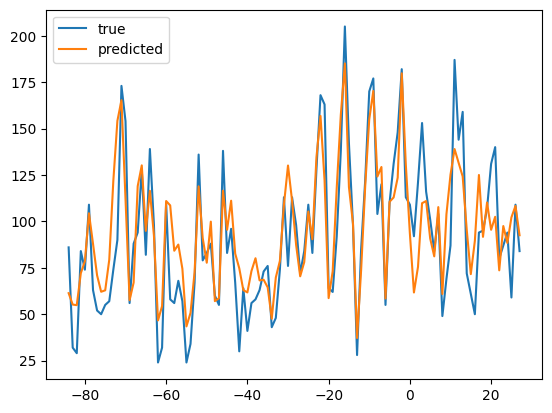

interpretable
params_alpha                                  NaN
params_distance__inverse                      NaN
params_interpretable                         True
params_lags                                   NaN
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                             mean
params_readjust                               NaN
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                    False
Name: 165, dtype: object


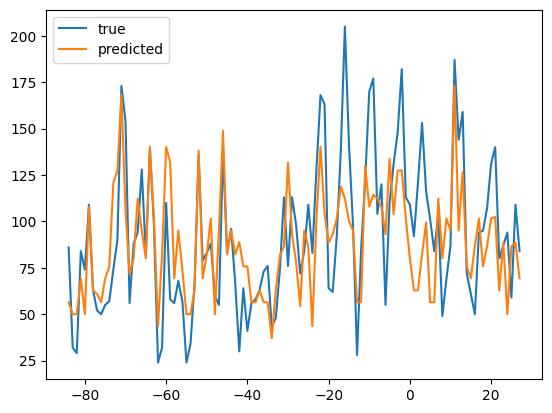

protest
grounded
params_distance__inverse           False
params_interpretable                 NaN
params_lags                          NaN
params_lam                           NaN
params_max_depth                     NaN
params_max_features                  NaN
params_method                   distance
params_min_samples_leaf              NaN
params_min_samples_split             NaN
params_n_estimators                  NaN
params_n_splines                     NaN
params_normalize                    none
params_socioeconomic__k              NaN
params_socioeconomic__method         NaN
params_spline_order                  NaN
params_training_interval            28.0
params_use_autoregressor             NaN
Name: 17, dtype: object


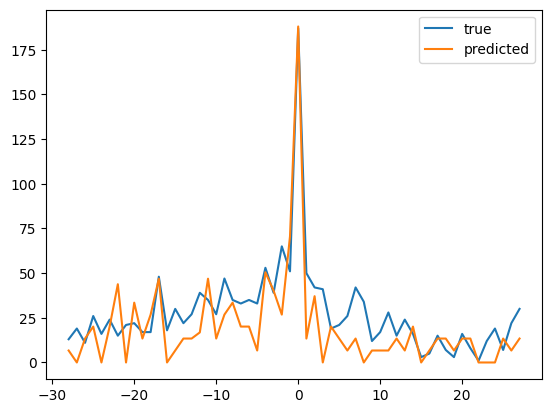

linear
params_distance__inverse                      NaN
params_interpretable                         True
params_lags                                   7.0
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                             mean
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                    336.0
params_use_autoregressor                     True
Name: 126, dtype: object


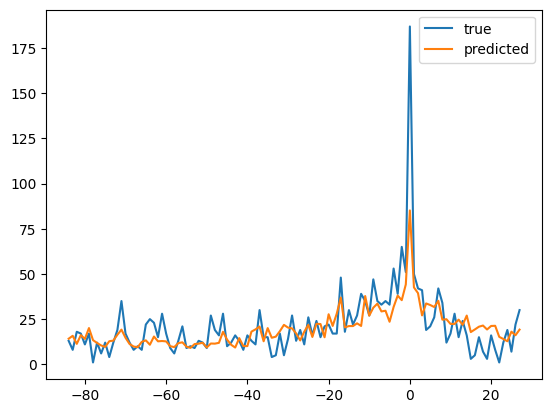

nonlinear
params_distance__inverse                  NaN
params_interpretable                      NaN
params_lags                               NaN
params_lam                                NaN
params_max_depth                         20.0
params_max_features                      sqrt
params_method                   random_forest
params_min_samples_leaf                   4.0
params_min_samples_split                  5.0
params_n_estimators                     100.0
params_n_splines                          NaN
params_normalize                         mean
params_socioeconomic__k                   NaN
params_socioeconomic__method              NaN
params_spline_order                       NaN
params_training_interval                336.0
params_use_autoregressor                False
Name: 351, dtype: object


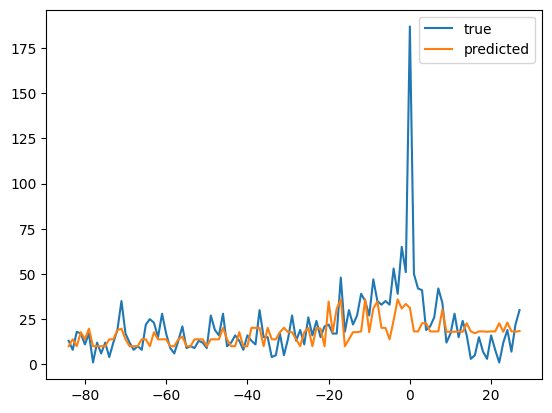

interpretable
params_distance__inverse                      NaN
params_interpretable                         True
params_lags                                   NaN
params_lam                                    NaN
params_max_depth                              NaN
params_max_features                           NaN
params_method                   linear_regression
params_min_samples_leaf                       NaN
params_min_samples_split                      NaN
params_n_estimators                           NaN
params_n_splines                              NaN
params_normalize                             mean
params_socioeconomic__k                       NaN
params_socioeconomic__method                  NaN
params_spline_order                           NaN
params_training_interval                     84.0
params_use_autoregressor                    False
Name: 204, dtype: object


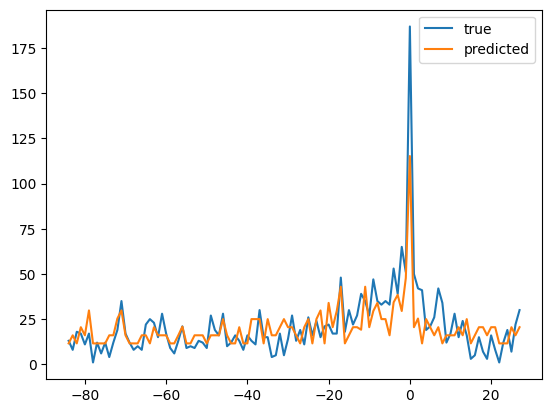

protest
grounded


IndexError: single positional indexer is out-of-bounds

In [18]:
for s in study_names:
    study = optuna.load_study(study_name=s, storage=db)
    print(s.split("_")[-2])
    df = study.trials_dataframe()

    for g in ["grounded", "linear", "nonlinear"]:
        print(g)
        best_trial = (
            df[df["user_attrs_method_group"] == g]
            .sort_values("user_attrs_rmse_dev")
            .iloc[0]
        )
        print(best_trial[[p for p in df.columns if p.startswith("params_")]])
        ts = pd.DataFrame(json.loads(best_trial["user_attrs_comparison_df"]))
        ts.index = ts.index.astype(int)
        ts.loc[-3 * 28 : 28].plot()
        plt.show()
    print("interpretable")
    best_trial = (
        df[
            (df["params_interpretable"] == True)
            & (df["params_use_autoregressor"] == False)
        ]
        .sort_values("user_attrs_rmse_dev")
        .iloc[0]
    )
    print(best_trial[[p for p in df.columns if p.startswith("params_")]])
    ts = pd.DataFrame(json.loads(best_trial["user_attrs_comparison_df"]))
    ts.index = ts.index.astype(int)
    ts.loc[-3 * 28 : 28].plot()
    plt.show()
    print("====================================")

In [33]:
import optuna

db = "sqlite:///../../hyperopt/synth_single_protests_v8.db"
studies = optuna.study.get_all_study_summaries(storage=db)
study_names = [s.study_name for s in studies]
study_names

['88f88563bb2473fcf326a15820d0742c_topic_focused',
 '17a695052dee7eec3ae0594fef190066_topic_focused',
 'c4d12e6a8f0438e48caf11414571f77d_topic_focused',
 '6d8d94699a4daf263087c7026b1d5e44_topic_focused',
 '9dbe37cdf70b5b3eefe21a7cc11b3183_topic_focused',
 '674bf5aef58bbd6e004ff9e56f70ce21_topic_focused',
 '6c4e19271292503b44325812a49ac7a9_topic_focused',
 'd520390da4052b97f6e40bc8e3aa7442_topic_focused',
 'b96976a6cd58a6291be66ce8ab22997e_topic_focused',
 '418d2aa2a3e4f7d344e9b21134207d3c_topic_focused',
 '82d81064ec7d554f63f65c26ed98e2d6_topic_focused',
 'f71339adc3c783160eac1be83a95553a_topic_focused',
 '44181e2fb1e3a4565de5ec5a00739d3c_topic_focused',
 '293b2d980d5ab8bd48861c1e7f3d1d97_topic_focused',
 '548bf1039804ac554b0fe54d82221a88_topic_focused',
 '69d6e86d4176758e71b9e493a4df5d21_protest_focused',
 '302ef4cef1922385b61aea7394619fe3_protest_focused',
 'bbf6bbe0bb69ea3ab2b4fbe69d5115bb_topic_focused',
 'bbf6bbe0bb69ea3ab2b4fbe69d5115bb_protest_focused',
 '14ddd372a1cc4eb342611b4

topic


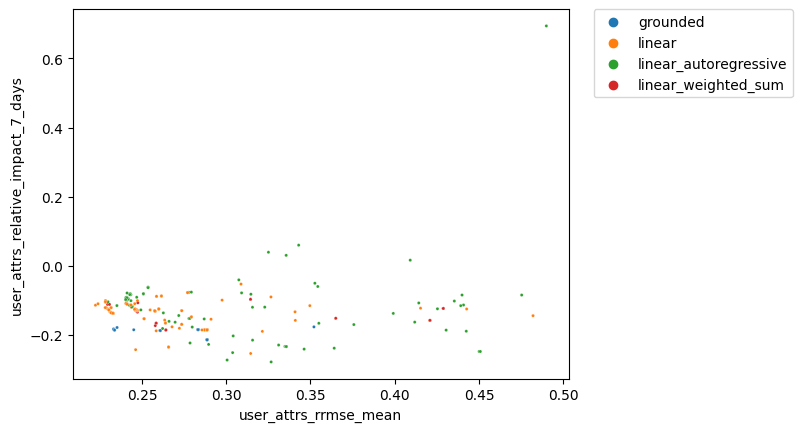

topic


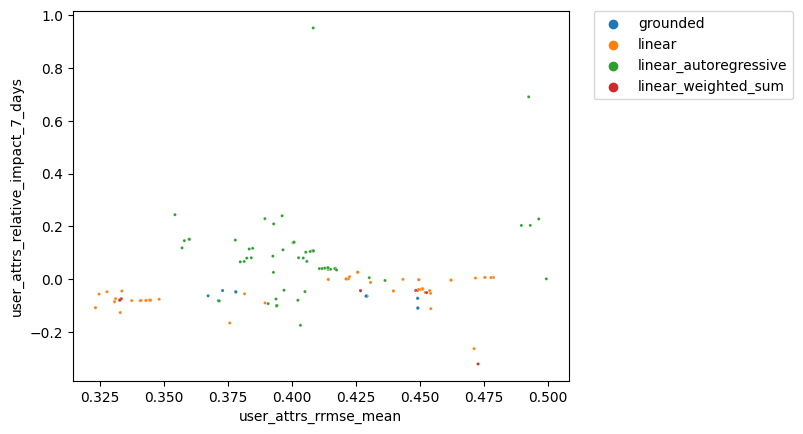

topic


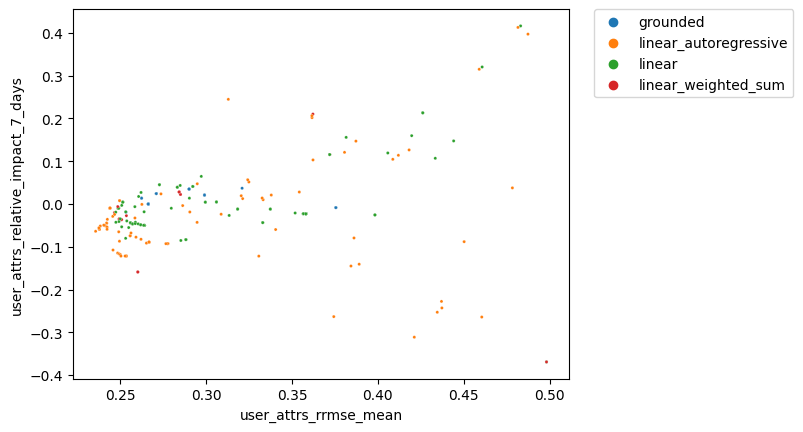

topic


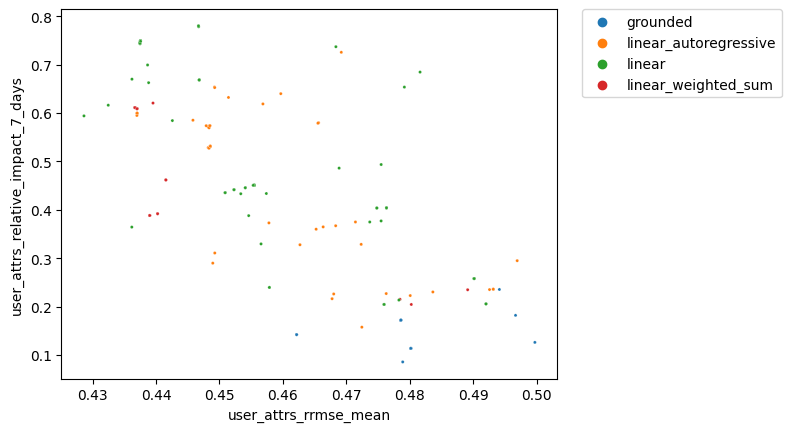

topic


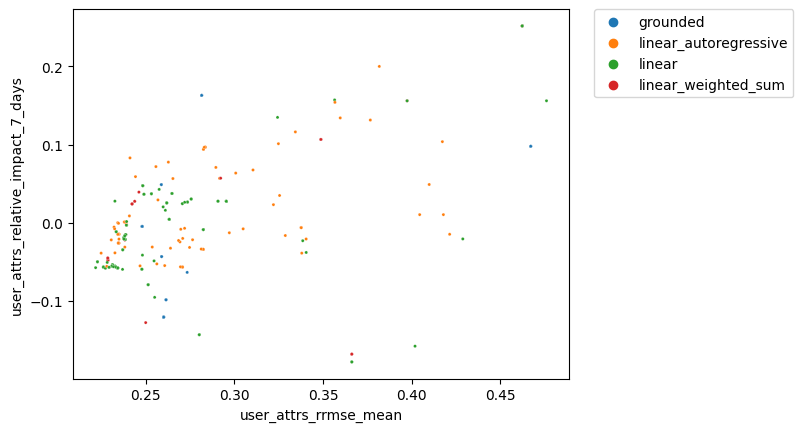

topic


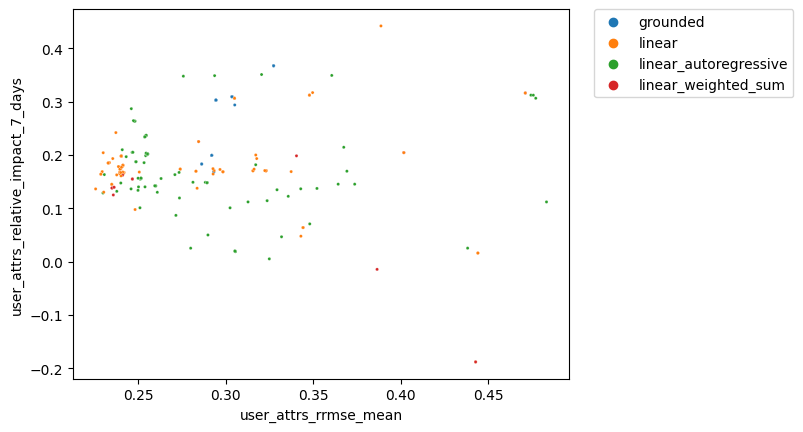

topic


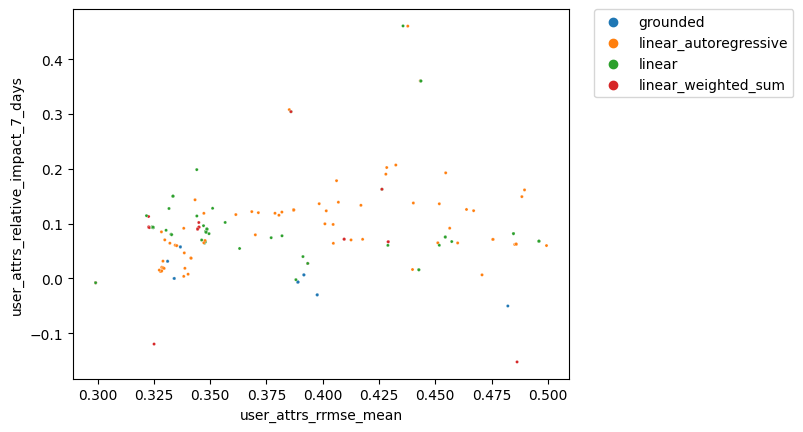

topic


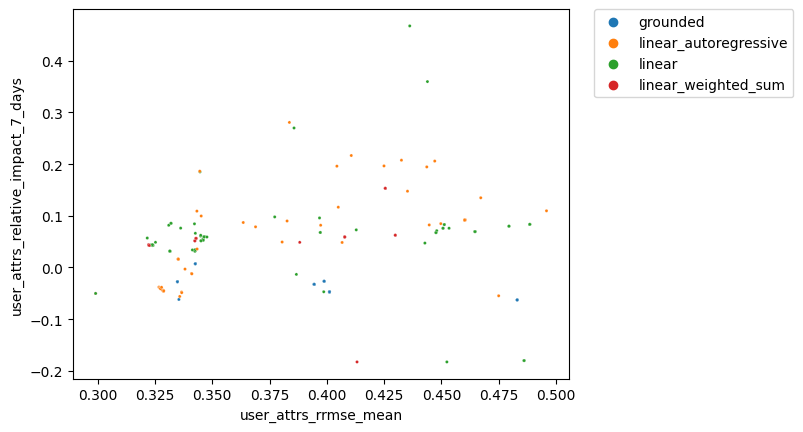

topic


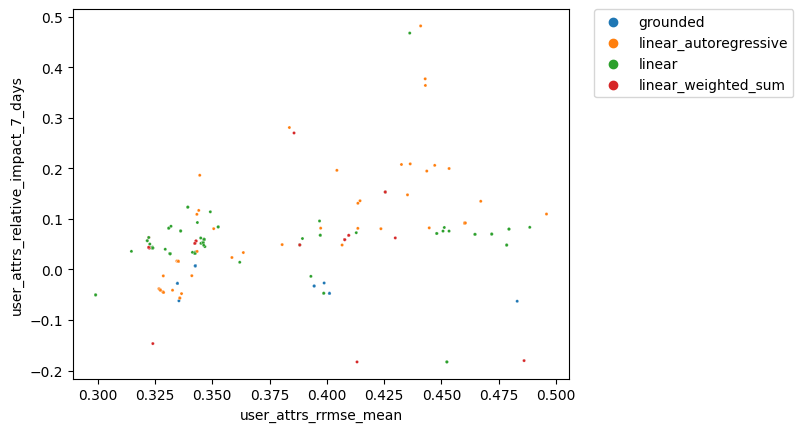

topic


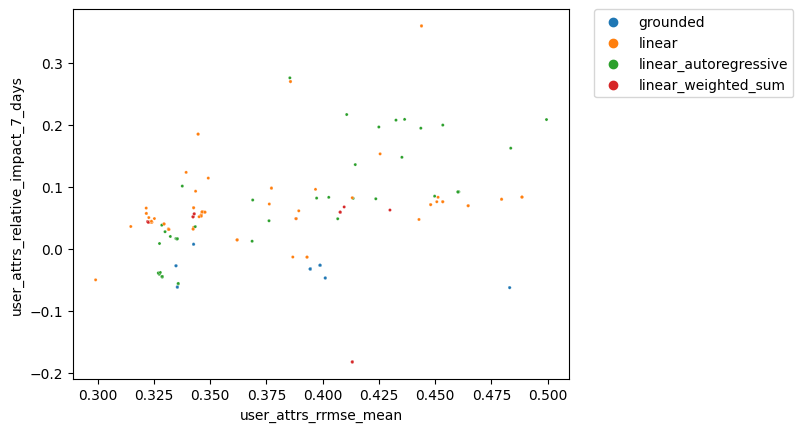

topic


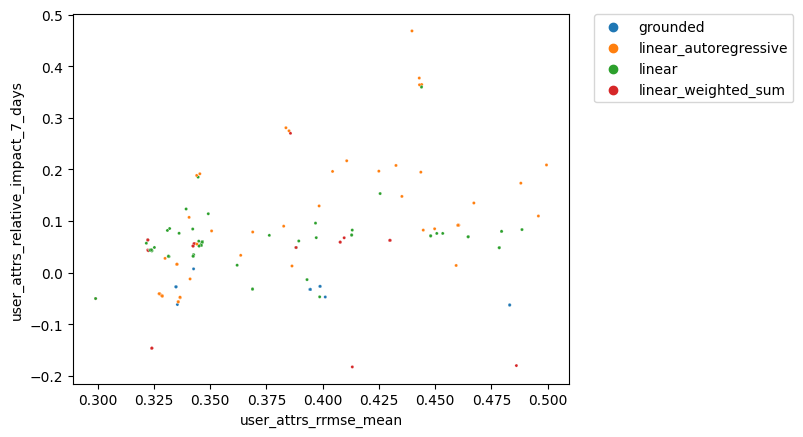

topic


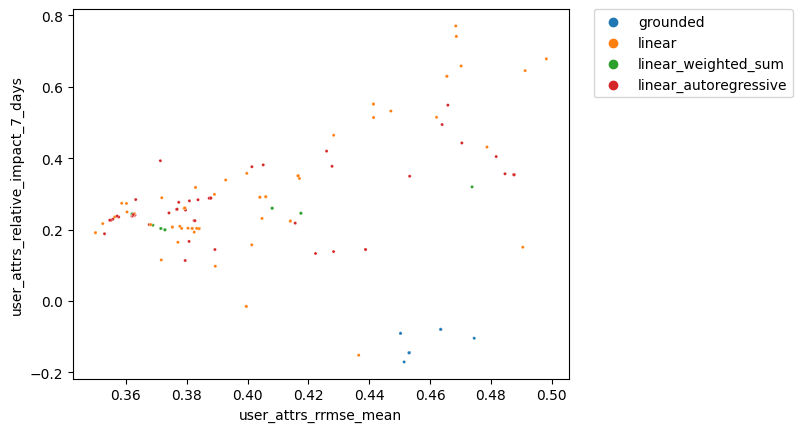

topic


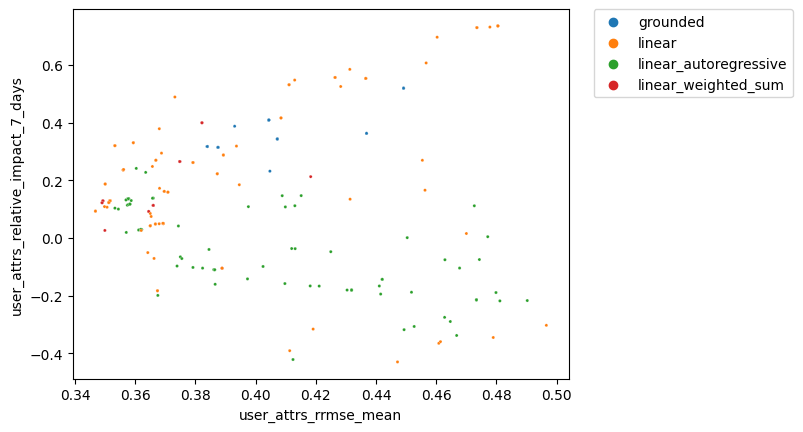

topic


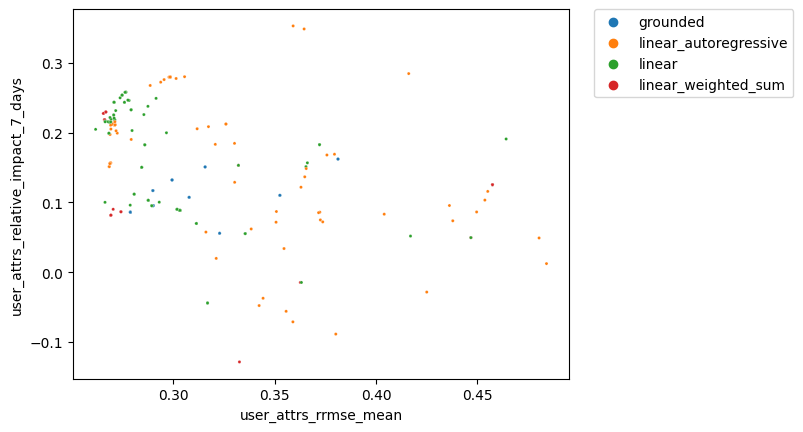

topic


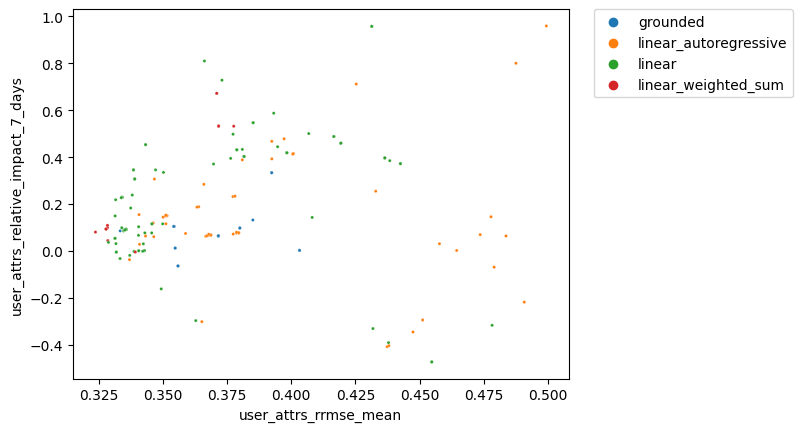

protest


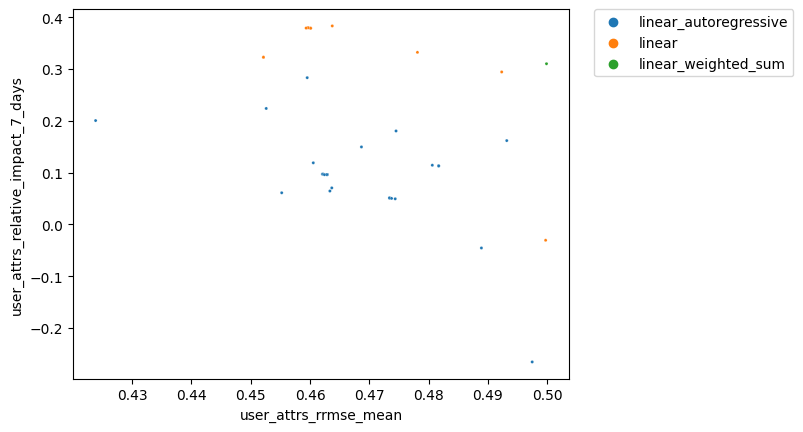

protest


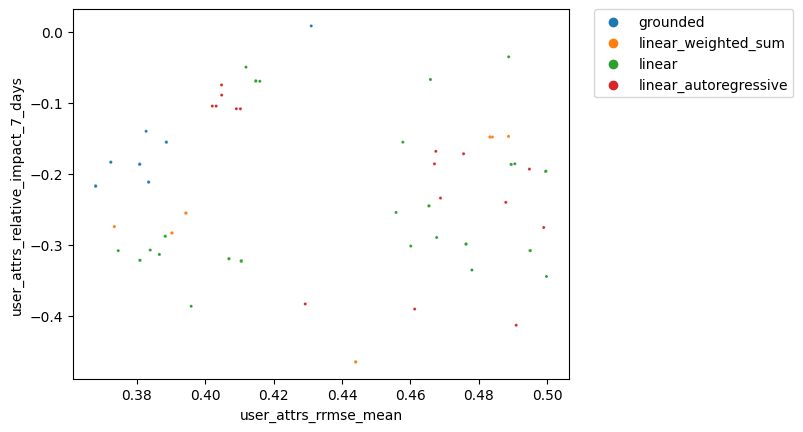

topic


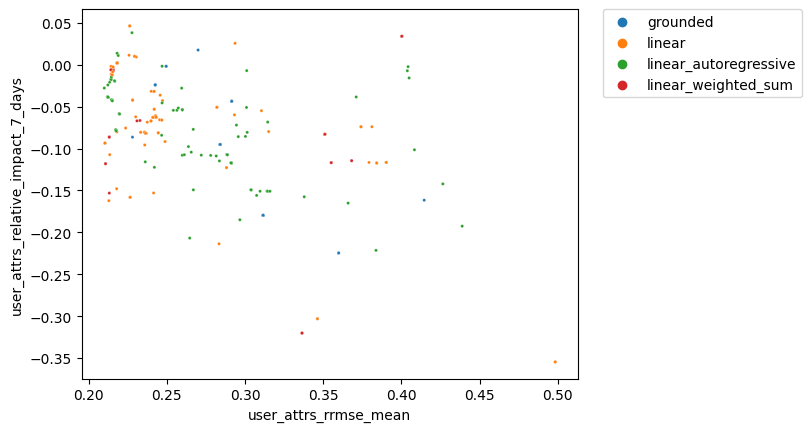

protest


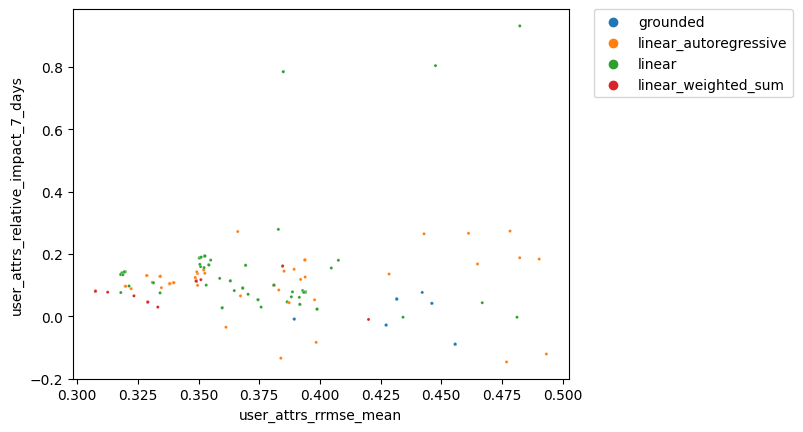

topic


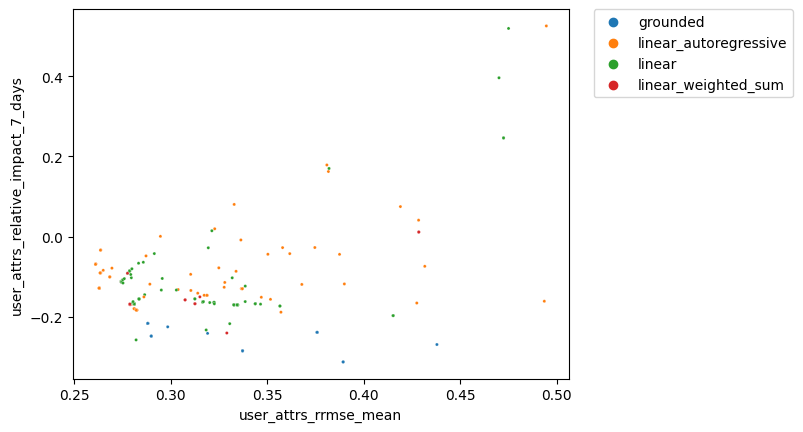

topic


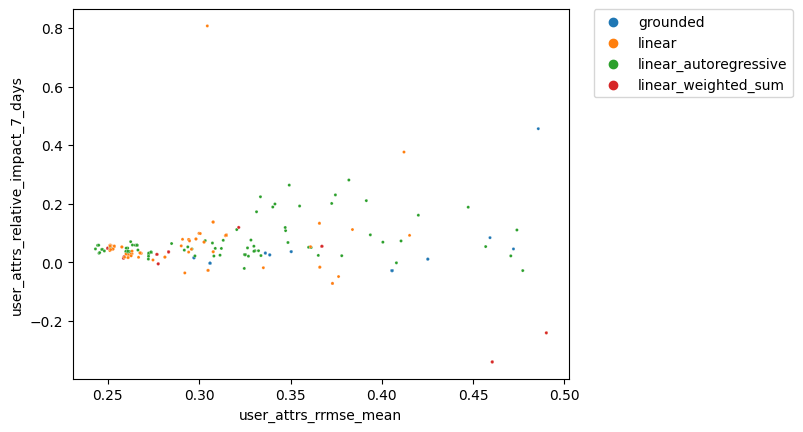

protest


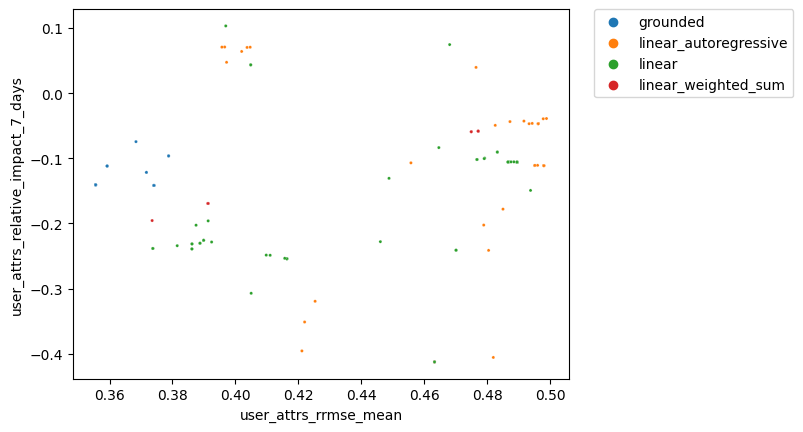

topic


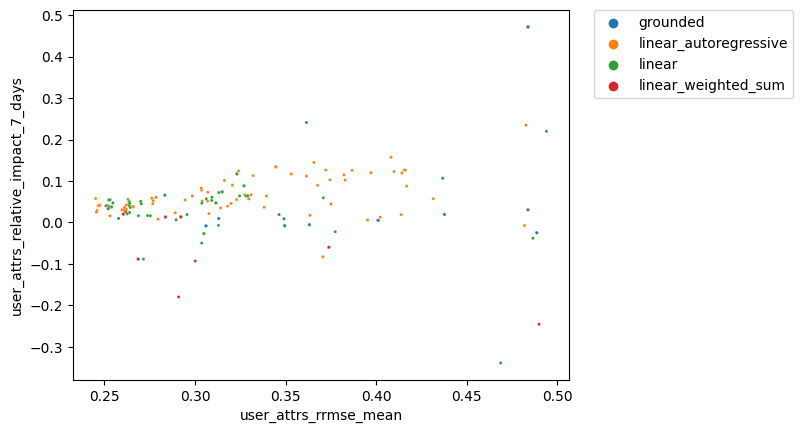

topic


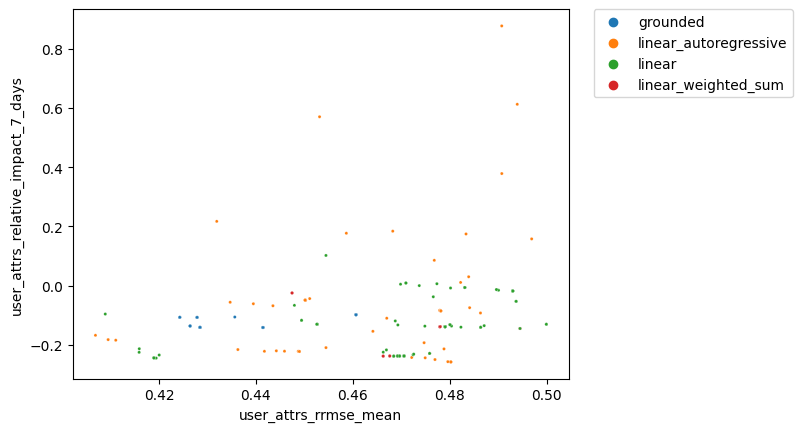

protest


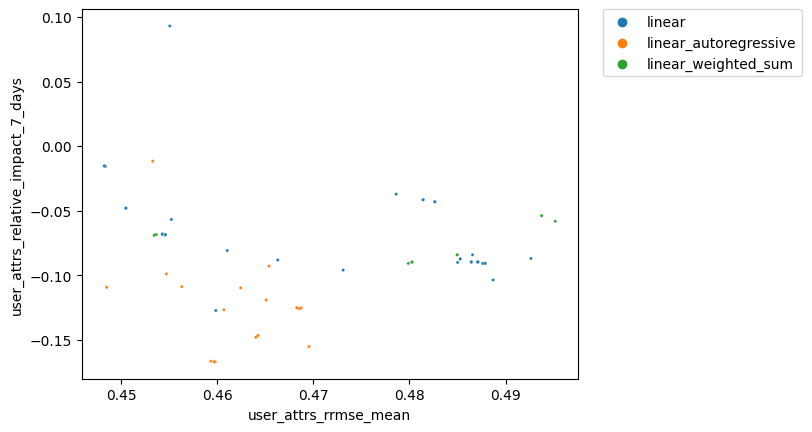

protest


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


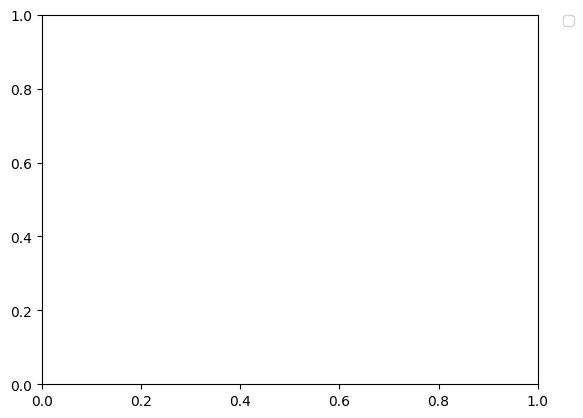

protest


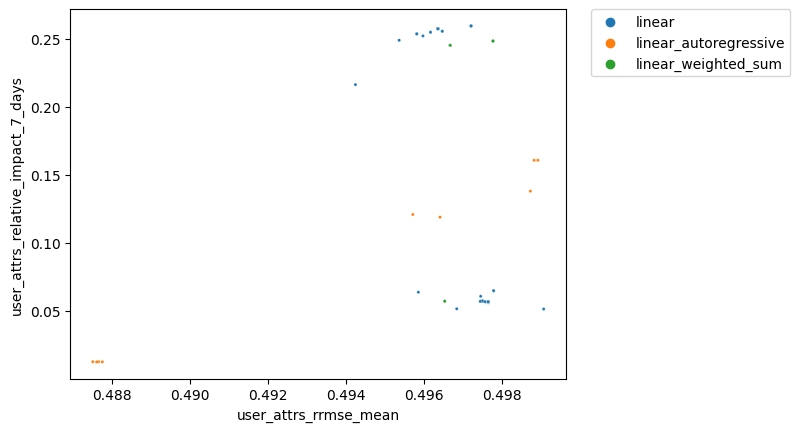

protest


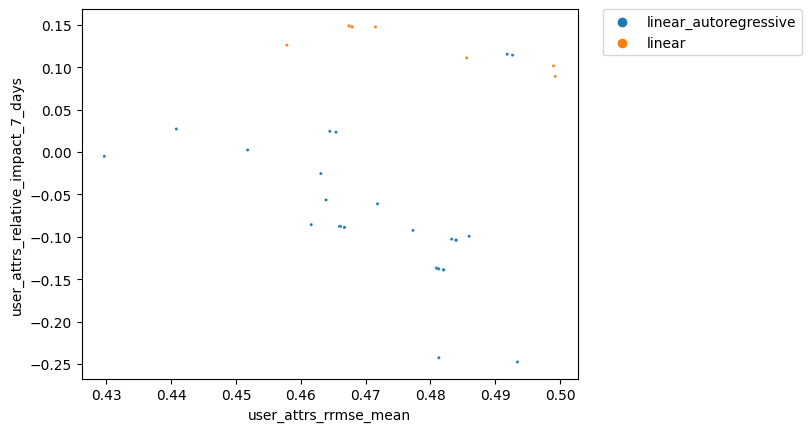

protest


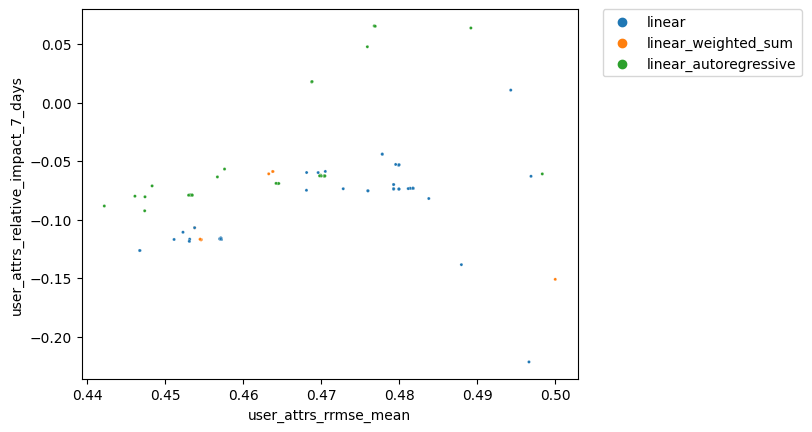

topic


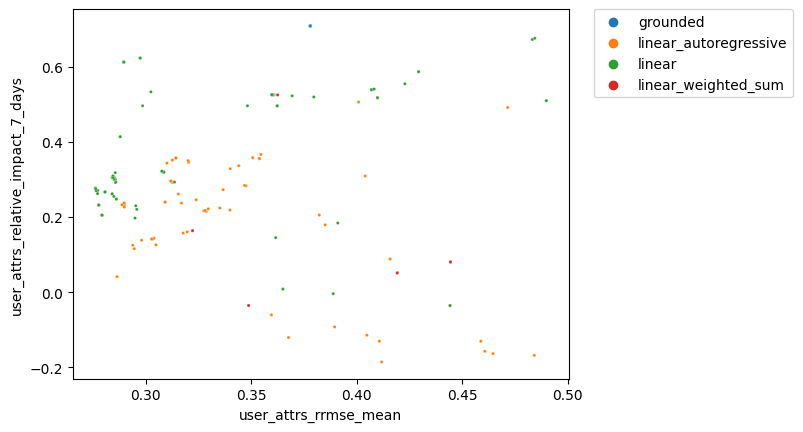

protest


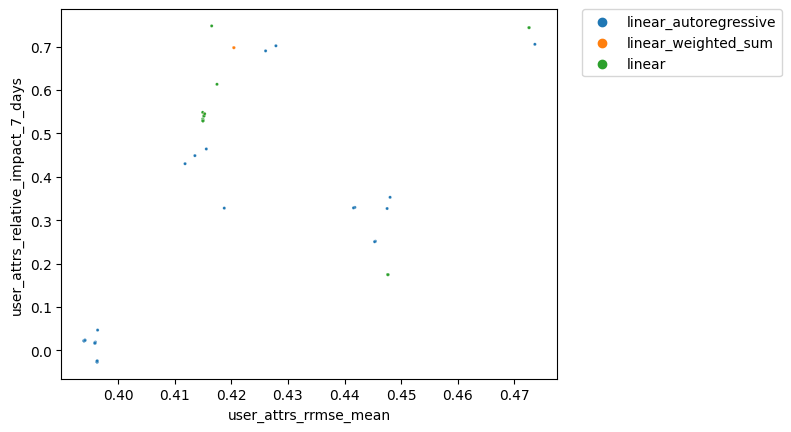

topic


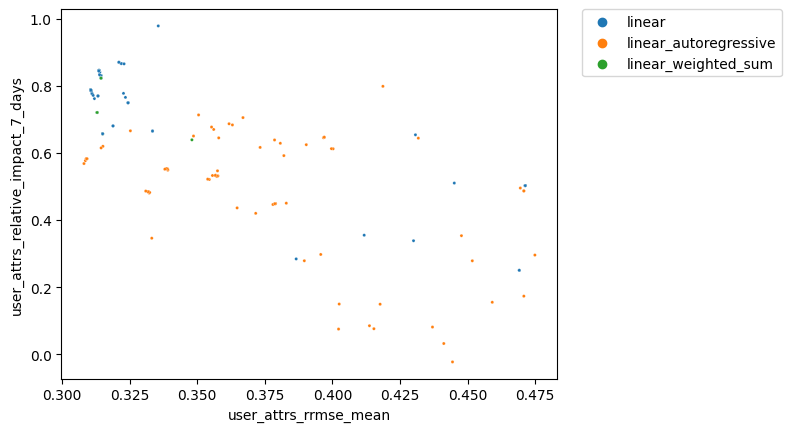

protest


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


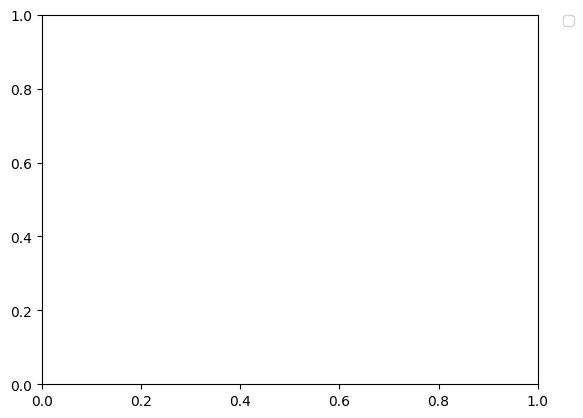

topic


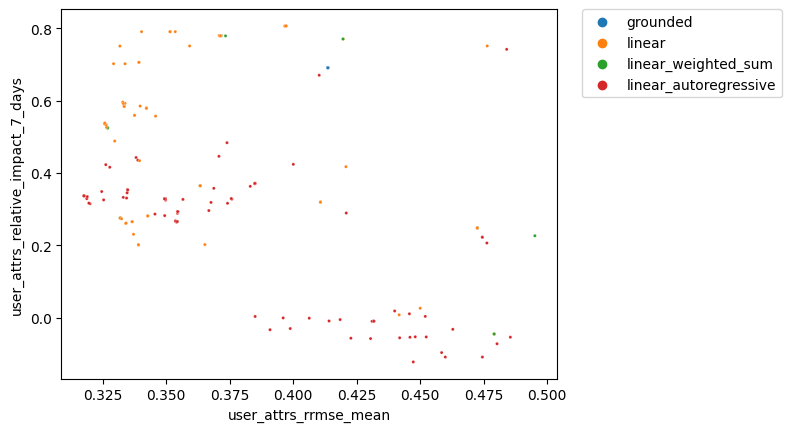

protest


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


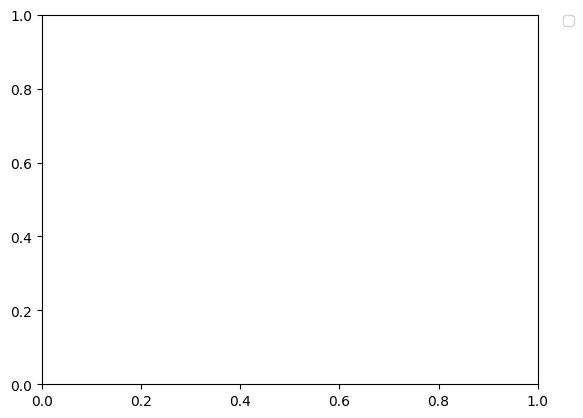

protest


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


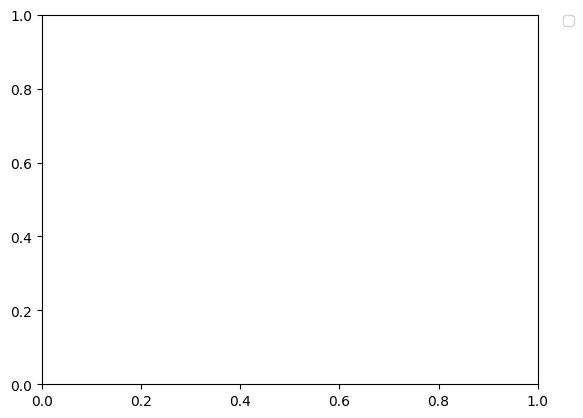

topic


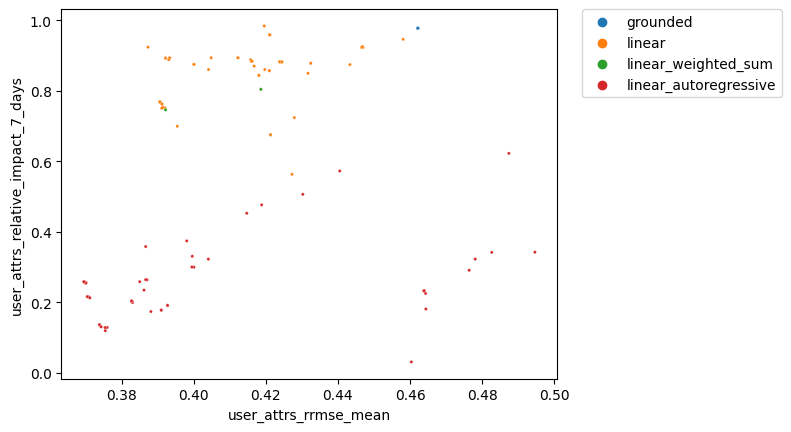

protest


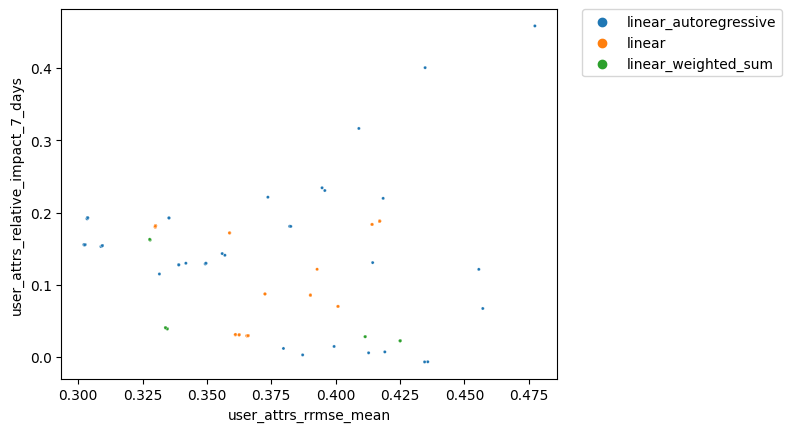

In [34]:
for s in study_names:
    study = optuna.load_study(study_name=s, storage=db)
    print(s.split("_")[-2])
    df = study.trials_dataframe()
    df = df[df.state == "COMPLETE"]
    df = df[(df["value"] < 0.5) & (df["user_attrs_relative_impact_7_days"].abs() < 1)]
    hue = "user_attrs_method_group"
    # hue = "params_method"
    sns.scatterplot(
        data=df,
        x="user_attrs_rrmse_mean",
        y="user_attrs_relative_impact_7_days",
        hue=hue,
        s=5,
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    plt.show()

In [50]:
studies = [optuna.load_study(study_name=s, storage=db) for s in study_names]
best_trials = [s.best_trial for s in studies]
comparison_dfs = [
    pd.DataFrame(json.loads(t.user_attrs["comparison_df"])) for t in best_trials
]
comparison_dfs = [df.reset_index(drop=True) for df in comparison_dfs]
comparison_dfs = [df.iloc[-28 * 2 :] for df in comparison_dfs]
# comparison_dfs = [df / df.mean() for df in comparison_dfs]
comparison_dfs = [df.reset_index(drop=True) for df in comparison_dfs]

In [56]:
# for comparison_df in comparison_dfs:
#     # aggregate by week
#     comparison_df = comparison_df.groupby(comparison_df.index // 7).mean()
#     comparison_df.plot()
#     plt.show()

In [82]:
best_trials_df.columns

Index(['alpha', 'interpretable', 'method', 'normalize', 'readjust',
       'training_interval', 'use_autoregressor', 'Unnamed: 0', 'admin1',
       'assoc_actor_1', 'co_terms', 'comparison_df',
       'comparison_df_normalized', 'csv', 'discourse_type', 'end_date',
       'event_date', 'hash', 'impact_14_days', 'impact_1_days',
       'impact_21_days', 'impact_28_days', 'impact_2_days', 'impact_3_days',
       'impact_7_days', 'location', 'method_group', 'n_control_regions',
       'n_theoretical_control_regions', 'notes', 'prediction_interval',
       'protest_group', 'region_code', 'relative_impact_14_days',
       'relative_impact_1_days', 'relative_impact_21_days',
       'relative_impact_28_days', 'relative_impact_2_days',
       'relative_impact_3_days', 'relative_impact_7_days', 'rrmse_mean',
       'rrmse_std', 'rrmses', 'seed', 'size', 'source', 'start_date',
       'sub_event_type', 'weekday', 'lags', 'distance__inverse'],
      dtype='object')

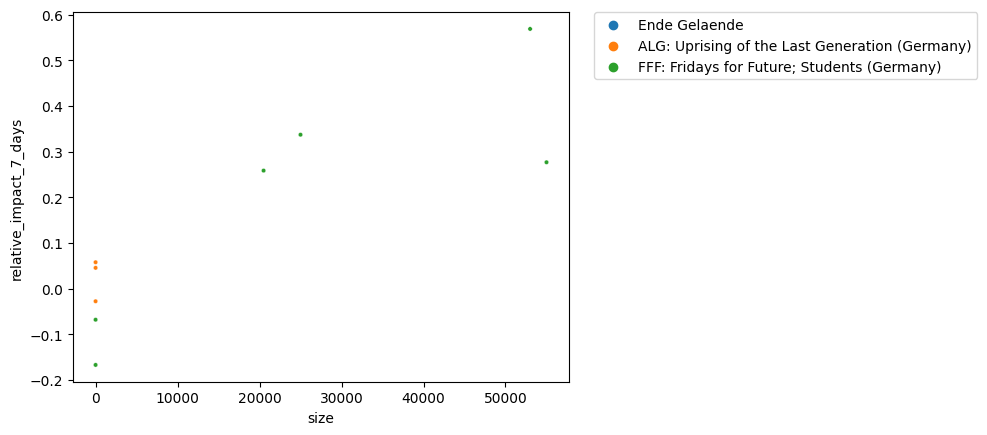

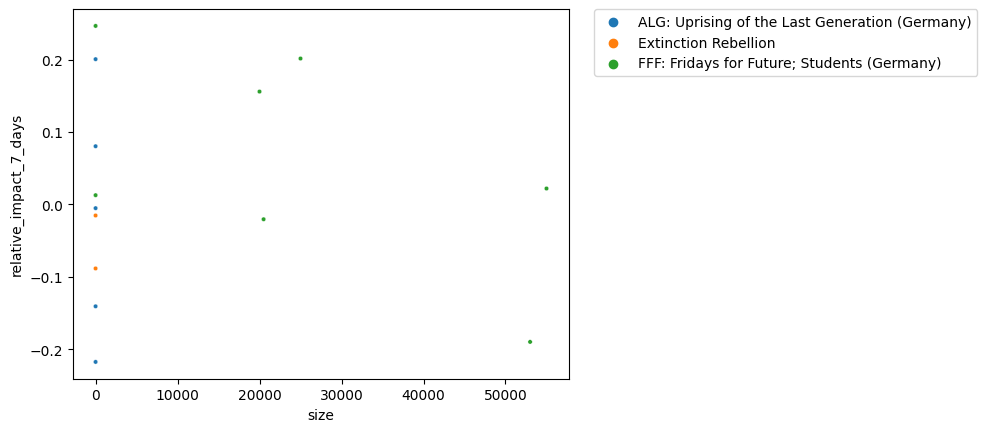

In [84]:
best_trials_df = pd.DataFrame([dict(**t.params, **t.user_attrs) for t in best_trials])
df = best_trials_df[best_trials_df["discourse_type"] == "topic_focused"]
sns.scatterplot(
    data=df, x="size", y="relative_impact_7_days", hue="assoc_actor_1", s=10
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()
df = best_trials_df[best_trials_df["discourse_type"] == "protest_focused"]
sns.scatterplot(
    data=df, x="size", y="relative_impact_7_days", hue="assoc_actor_1", s=10
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()